In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 468)
(3944610, 8)
validation
(464344, 468)
(464344, 8)
test
(574820, 468)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/395 [..............................] - ETA: 8:40 - loss: 2.2025 - STD: 0.0748 - MAE: 0.2159


  6/395 [..............................] - ETA: 4s - loss: 2.0977 - STD: 0.0433 - MAE: 0.2168  


 10/395 [..............................] - ETA: 4s - loss: 2.0848 - STD: 0.0433 - MAE: 0.2166


 15/395 [>.............................] - ETA: 4s - loss: 2.0739 - STD: 0.0390 - MAE: 0.2167


 20/395 [>.............................] - ETA: 4s - loss: 2.0680 - STD: 0.0381 - MAE: 0.2166


 25/395 [>.............................] - ETA: 4s - loss: 2.0617 - STD: 0.0369 - MAE: 0.2165


 29/395 [=>............................] - ETA: 4s - loss: 2.0559 - STD: 0.0367 - MAE: 0.2163


 34/395 [=>............................] - ETA: 4s - loss: 2.0457 - STD: 0.0372 - MAE: 0.2160


 38/395 [=>............................] - ETA: 4s - loss: 2.0356 - STD: 0.0388 - MAE: 0.2155


 43/395 [==>...........................] - ETA: 4s - loss: 2.0213 - STD: 0.0423 - MAE: 0.2146


 48/395 [==>...........................] - ETA: 4s - loss: 2.0063 - STD: 0.0454 - MAE: 0.2138


 53/395 [===>..........................] - ETA: 4s - loss: 1.9897 - STD: 0.0483 - MAE: 0.2129


 58/395 [===>..........................] - ETA: 4s - loss: 1.9704 - STD: 0.0513 - MAE: 0.2120


 63/395 [===>..........................] - ETA: 4s - loss: 1.9484 - STD: 0.0546 - MAE: 0.2108


 67/395 [====>.........................] - ETA: 4s - loss: 1.9295 - STD: 0.0576 - MAE: 0.2097


 72/395 [====>.........................] - ETA: 3s - loss: 1.9057 - STD: 0.0615 - MAE: 0.2084


 77/395 [====>.........................] - ETA: 3s - loss: 1.8819 - STD: 0.0653 - MAE: 0.2069


 82/395 [=====>........................] - ETA: 3s - loss: 1.8591 - STD: 0.0691 - MAE: 0.2055


 87/395 [=====>........................] - ETA: 3s - loss: 1.8383 - STD: 0.0727 - MAE: 0.2042


 91/395 [=====>........................] - ETA: 3s - loss: 1.8230 - STD: 0.0754 - MAE: 0.2031


 95/395 [======>.......................] - ETA: 3s - loss: 1.8085 - STD: 0.0779 - MAE: 0.2022


100/395 [======>.......................] - ETA: 3s - loss: 1.7916 - STD: 0.0807 - MAE: 0.2011


105/395 [======>.......................] - ETA: 3s - loss: 1.7761 - STD: 0.0834 - MAE: 0.2000


110/395 [=======>......................] - ETA: 3s - loss: 1.7615 - STD: 0.0859 - MAE: 0.1990


115/395 [=======>......................] - ETA: 3s - loss: 1.7475 - STD: 0.0882 - MAE: 0.1981


120/395 [========>.....................] - ETA: 3s - loss: 1.7345 - STD: 0.0905 - MAE: 0.1972


125/395 [========>.....................] - ETA: 3s - loss: 1.7221 - STD: 0.0925 - MAE: 0.1963


130/395 [========>.....................] - ETA: 3s - loss: 1.7103 - STD: 0.0945 - MAE: 0.1955


135/395 [=========>....................] - ETA: 3s - loss: 1.6993 - STD: 0.0964 - MAE: 0.1947


140/395 [=========>....................] - ETA: 3s - loss: 1.6889 - STD: 0.0981 - MAE: 0.1940


145/395 [==========>...................] - ETA: 3s - loss: 1.6789 - STD: 0.0999 - MAE: 0.1932


149/395 [==========>...................] - ETA: 3s - loss: 1.6712 - STD: 0.1011 - MAE: 0.1927


154/395 [==========>...................] - ETA: 2s - loss: 1.6621 - STD: 0.1027 - MAE: 0.1920


159/395 [===========>..................] - ETA: 2s - loss: 1.6532 - STD: 0.1042 - MAE: 0.1914


164/395 [===========>..................] - ETA: 2s - loss: 1.6446 - STD: 0.1056 - MAE: 0.1908


169/395 [===========>..................] - ETA: 2s - loss: 1.6364 - STD: 0.1070 - MAE: 0.1901


174/395 [============>.................] - ETA: 2s - loss: 1.6284 - STD: 0.1083 - MAE: 0.1895


178/395 [============>.................] - ETA: 2s - loss: 1.6222 - STD: 0.1093 - MAE: 0.1891


183/395 [============>.................] - ETA: 2s - loss: 1.6147 - STD: 0.1106 - MAE: 0.1885


188/395 [=============>................] - ETA: 2s - loss: 1.6075 - STD: 0.1118 - MAE: 0.1880


193/395 [=============>................] - ETA: 2s - loss: 1.6006 - STD: 0.1130 - MAE: 0.1874


198/395 [==============>...............] - ETA: 2s - loss: 1.5937 - STD: 0.1141 - MAE: 0.1869


202/395 [==============>...............] - ETA: 2s - loss: 1.5883 - STD: 0.1150 - MAE: 0.1865


207/395 [==============>...............] - ETA: 2s - loss: 1.5819 - STD: 0.1161 - MAE: 0.1860


212/395 [===============>..............] - ETA: 2s - loss: 1.5755 - STD: 0.1172 - MAE: 0.1855


216/395 [===============>..............] - ETA: 2s - loss: 1.5712 - STD: 0.1180 - MAE: 0.1851


220/395 [===============>..............] - ETA: 2s - loss: 1.5664 - STD: 0.1188 - MAE: 0.1847


225/395 [================>.............] - ETA: 2s - loss: 1.5606 - STD: 0.1198 - MAE: 0.1842


230/395 [================>.............] - ETA: 2s - loss: 1.5546 - STD: 0.1208 - MAE: 0.1837


234/395 [================>.............] - ETA: 2s - loss: 1.5500 - STD: 0.1215 - MAE: 0.1833


238/395 [=================>............] - ETA: 2s - loss: 1.5455 - STD: 0.1223 - MAE: 0.1830


242/395 [=================>............] - ETA: 2s - loss: 1.5410 - STD: 0.1231 - MAE: 0.1826


246/395 [=================>............] - ETA: 2s - loss: 1.5367 - STD: 0.1238 - MAE: 0.1822


251/395 [==================>...........] - ETA: 2s - loss: 1.5315 - STD: 0.1247 - MAE: 0.1818


256/395 [==================>...........] - ETA: 2s - loss: 1.5265 - STD: 0.1256 - MAE: 0.1814


261/395 [==================>...........] - ETA: 1s - loss: 1.5216 - STD: 0.1264 - MAE: 0.1809


266/395 [===================>..........] - ETA: 1s - loss: 1.5168 - STD: 0.1273 - MAE: 0.1805


270/395 [===================>..........] - ETA: 1s - loss: 1.5129 - STD: 0.1279 - MAE: 0.1802


274/395 [===================>..........] - ETA: 1s - loss: 1.5092 - STD: 0.1286 - MAE: 0.1799


279/395 [====================>.........] - ETA: 1s - loss: 1.5046 - STD: 0.1293 - MAE: 0.1795


284/395 [====================>.........] - ETA: 1s - loss: 1.5002 - STD: 0.1301 - MAE: 0.1791


289/395 [====================>.........] - ETA: 1s - loss: 1.4957 - STD: 0.1308 - MAE: 0.1787


294/395 [=====================>........] - ETA: 1s - loss: 1.4915 - STD: 0.1316 - MAE: 0.1783


298/395 [=====================>........] - ETA: 1s - loss: 1.4882 - STD: 0.1321 - MAE: 0.1781


302/395 [=====================>........] - ETA: 1s - loss: 1.4850 - STD: 0.1327 - MAE: 0.1778


306/395 [======================>.......] - ETA: 1s - loss: 1.4821 - STD: 0.1333 - MAE: 0.1775


311/395 [======================>.......] - ETA: 1s - loss: 1.4783 - STD: 0.1340 - MAE: 0.1772


316/395 [=======================>......] - ETA: 1s - loss: 1.4744 - STD: 0.1346 - MAE: 0.1768


321/395 [=======================>......] - ETA: 1s - loss: 1.4708 - STD: 0.1352 - MAE: 0.1765


326/395 [=======================>......] - ETA: 0s - loss: 1.4671 - STD: 0.1359 - MAE: 0.1762


331/395 [========================>.....] - ETA: 0s - loss: 1.4635 - STD: 0.1365 - MAE: 0.1759


336/395 [========================>.....] - ETA: 0s - loss: 1.4599 - STD: 0.1371 - MAE: 0.1755


341/395 [========================>.....] - ETA: 0s - loss: 1.4564 - STD: 0.1377 - MAE: 0.1752


345/395 [=========================>....] - ETA: 0s - loss: 1.4536 - STD: 0.1381 - MAE: 0.1750


349/395 [=========================>....] - ETA: 0s - loss: 1.4509 - STD: 0.1386 - MAE: 0.1747


353/395 [=========================>....] - ETA: 0s - loss: 1.4482 - STD: 0.1391 - MAE: 0.1745


358/395 [==========================>...] - ETA: 0s - loss: 1.4449 - STD: 0.1396 - MAE: 0.1742


363/395 [==========================>...] - ETA: 0s - loss: 1.4416 - STD: 0.1402 - MAE: 0.1739


368/395 [==========================>...] - ETA: 0s - loss: 1.4384 - STD: 0.1407 - MAE: 0.1736


373/395 [===========================>..] - ETA: 0s - loss: 1.4352 - STD: 0.1412 - MAE: 0.1734


377/395 [===========================>..] - ETA: 0s - loss: 1.4329 - STD: 0.1416 - MAE: 0.1731


382/395 [============================>.] - ETA: 0s - loss: 1.4299 - STD: 0.1421 - MAE: 0.1729


387/395 [============================>.] - ETA: 0s - loss: 1.4270 - STD: 0.1426 - MAE: 0.1726


392/395 [============================>.] - ETA: 0s - loss: 1.4242 - STD: 0.1431 - MAE: 0.1724


395/395 [==============================] - 8s 16ms/step - loss: 1.4225 - STD: 0.1433 - MAE: 0.1722 - val_loss: 1.2230 - val_STD: 0.1820 - val_MAE: 0.1508


Epoch 2/10000



  1/395 [..............................] - ETA: 15s - loss: 1.2098 - STD: 0.1804 - MAE: 0.1528


  5/395 [..............................] - ETA: 5s - loss: 1.1985 - STD: 0.1810 - MAE: 0.1520 


 10/395 [..............................] - ETA: 4s - loss: 1.1985 - STD: 0.1811 - MAE: 0.1518


 15/395 [>.............................] - ETA: 4s - loss: 1.1966 - STD: 0.1812 - MAE: 0.1517


 19/395 [>.............................] - ETA: 4s - loss: 1.1938 - STD: 0.1813 - MAE: 0.1516


 23/395 [>.............................] - ETA: 4s - loss: 1.1935 - STD: 0.1815 - MAE: 0.1515


 28/395 [=>............................] - ETA: 4s - loss: 1.1929 - STD: 0.1818 - MAE: 0.1513


 33/395 [=>............................] - ETA: 4s - loss: 1.1913 - STD: 0.1819 - MAE: 0.1512


 38/395 [=>............................] - ETA: 4s - loss: 1.1918 - STD: 0.1821 - MAE: 0.1512


 43/395 [==>...........................] - ETA: 4s - loss: 1.1913 - STD: 0.1822 - MAE: 0.1511


 47/395 [==>...........................] - ETA: 4s - loss: 1.1920 - STD: 0.1823 - MAE: 0.1511


 52/395 [==>...........................] - ETA: 4s - loss: 1.1917 - STD: 0.1823 - MAE: 0.1511


 57/395 [===>..........................] - ETA: 4s - loss: 1.1911 - STD: 0.1824 - MAE: 0.1510


 62/395 [===>..........................] - ETA: 4s - loss: 1.1900 - STD: 0.1826 - MAE: 0.1509


 67/395 [====>.........................] - ETA: 4s - loss: 1.1895 - STD: 0.1827 - MAE: 0.1509


 72/395 [====>.........................] - ETA: 3s - loss: 1.1887 - STD: 0.1827 - MAE: 0.1508


 77/395 [====>.........................] - ETA: 3s - loss: 1.1874 - STD: 0.1828 - MAE: 0.1507


 82/395 [=====>........................] - ETA: 3s - loss: 1.1865 - STD: 0.1830 - MAE: 0.1506


 87/395 [=====>........................] - ETA: 3s - loss: 1.1854 - STD: 0.1831 - MAE: 0.1505


 92/395 [=====>........................] - ETA: 3s - loss: 1.1847 - STD: 0.1832 - MAE: 0.1504


 96/395 [======>.......................] - ETA: 3s - loss: 1.1838 - STD: 0.1833 - MAE: 0.1503


100/395 [======>.......................] - ETA: 3s - loss: 1.1827 - STD: 0.1834 - MAE: 0.1502


105/395 [======>.......................] - ETA: 3s - loss: 1.1819 - STD: 0.1835 - MAE: 0.1501


110/395 [=======>......................] - ETA: 3s - loss: 1.1812 - STD: 0.1836 - MAE: 0.1501


115/395 [=======>......................] - ETA: 3s - loss: 1.1805 - STD: 0.1838 - MAE: 0.1500


120/395 [========>.....................] - ETA: 3s - loss: 1.1799 - STD: 0.1838 - MAE: 0.1499


124/395 [========>.....................] - ETA: 3s - loss: 1.1793 - STD: 0.1839 - MAE: 0.1499


128/395 [========>.....................] - ETA: 3s - loss: 1.1787 - STD: 0.1840 - MAE: 0.1498


133/395 [=========>....................] - ETA: 3s - loss: 1.1782 - STD: 0.1841 - MAE: 0.1498


138/395 [=========>....................] - ETA: 3s - loss: 1.1776 - STD: 0.1842 - MAE: 0.1497


143/395 [=========>....................] - ETA: 3s - loss: 1.1771 - STD: 0.1843 - MAE: 0.1496


148/395 [==========>...................] - ETA: 3s - loss: 1.1763 - STD: 0.1844 - MAE: 0.1495


152/395 [==========>...................] - ETA: 2s - loss: 1.1759 - STD: 0.1845 - MAE: 0.1495


156/395 [==========>...................] - ETA: 2s - loss: 1.1753 - STD: 0.1846 - MAE: 0.1494


161/395 [===========>..................] - ETA: 2s - loss: 1.1744 - STD: 0.1847 - MAE: 0.1494


166/395 [===========>..................] - ETA: 2s - loss: 1.1733 - STD: 0.1848 - MAE: 0.1493


171/395 [===========>..................] - ETA: 2s - loss: 1.1726 - STD: 0.1849 - MAE: 0.1492


176/395 [============>.................] - ETA: 2s - loss: 1.1719 - STD: 0.1849 - MAE: 0.1492


180/395 [============>.................] - ETA: 2s - loss: 1.1714 - STD: 0.1850 - MAE: 0.1491


185/395 [=============>................] - ETA: 2s - loss: 1.1709 - STD: 0.1851 - MAE: 0.1490


190/395 [=============>................] - ETA: 2s - loss: 1.1703 - STD: 0.1852 - MAE: 0.1490


195/395 [=============>................] - ETA: 2s - loss: 1.1696 - STD: 0.1853 - MAE: 0.1489


200/395 [==============>...............] - ETA: 2s - loss: 1.1686 - STD: 0.1854 - MAE: 0.1488


205/395 [==============>...............] - ETA: 2s - loss: 1.1680 - STD: 0.1855 - MAE: 0.1488


209/395 [==============>...............] - ETA: 2s - loss: 1.1675 - STD: 0.1855 - MAE: 0.1487


214/395 [===============>..............] - ETA: 2s - loss: 1.1669 - STD: 0.1856 - MAE: 0.1487


219/395 [===============>..............] - ETA: 2s - loss: 1.1662 - STD: 0.1858 - MAE: 0.1486


224/395 [================>.............] - ETA: 2s - loss: 1.1658 - STD: 0.1859 - MAE: 0.1485


228/395 [================>.............] - ETA: 2s - loss: 1.1653 - STD: 0.1859 - MAE: 0.1485


233/395 [================>.............] - ETA: 1s - loss: 1.1646 - STD: 0.1860 - MAE: 0.1484


238/395 [=================>............] - ETA: 1s - loss: 1.1641 - STD: 0.1861 - MAE: 0.1483


243/395 [=================>............] - ETA: 1s - loss: 1.1634 - STD: 0.1862 - MAE: 0.1483


248/395 [=================>............] - ETA: 1s - loss: 1.1628 - STD: 0.1863 - MAE: 0.1482


253/395 [==================>...........] - ETA: 1s - loss: 1.1622 - STD: 0.1863 - MAE: 0.1482


258/395 [==================>...........] - ETA: 1s - loss: 1.1618 - STD: 0.1864 - MAE: 0.1481


263/395 [==================>...........] - ETA: 1s - loss: 1.1613 - STD: 0.1865 - MAE: 0.1480


268/395 [===================>..........] - ETA: 1s - loss: 1.1608 - STD: 0.1866 - MAE: 0.1480


273/395 [===================>..........] - ETA: 1s - loss: 1.1603 - STD: 0.1867 - MAE: 0.1479


278/395 [====================>.........] - ETA: 1s - loss: 1.1597 - STD: 0.1868 - MAE: 0.1479


283/395 [====================>.........] - ETA: 1s - loss: 1.1590 - STD: 0.1868 - MAE: 0.1478


287/395 [====================>.........] - ETA: 1s - loss: 1.1585 - STD: 0.1869 - MAE: 0.1478


292/395 [=====================>........] - ETA: 1s - loss: 1.1578 - STD: 0.1870 - MAE: 0.1477


297/395 [=====================>........] - ETA: 1s - loss: 1.1571 - STD: 0.1871 - MAE: 0.1476


302/395 [=====================>........] - ETA: 1s - loss: 1.1566 - STD: 0.1872 - MAE: 0.1476


307/395 [======================>.......] - ETA: 1s - loss: 1.1559 - STD: 0.1872 - MAE: 0.1475


311/395 [======================>.......] - ETA: 1s - loss: 1.1554 - STD: 0.1873 - MAE: 0.1475


315/395 [======================>.......] - ETA: 0s - loss: 1.1550 - STD: 0.1874 - MAE: 0.1474


320/395 [=======================>......] - ETA: 0s - loss: 1.1544 - STD: 0.1875 - MAE: 0.1474


325/395 [=======================>......] - ETA: 0s - loss: 1.1538 - STD: 0.1875 - MAE: 0.1473


330/395 [========================>.....] - ETA: 0s - loss: 1.1531 - STD: 0.1876 - MAE: 0.1472


335/395 [========================>.....] - ETA: 0s - loss: 1.1525 - STD: 0.1877 - MAE: 0.1472


340/395 [========================>.....] - ETA: 0s - loss: 1.1519 - STD: 0.1878 - MAE: 0.1471


345/395 [=========================>....] - ETA: 0s - loss: 1.1514 - STD: 0.1878 - MAE: 0.1471


350/395 [=========================>....] - ETA: 0s - loss: 1.1509 - STD: 0.1879 - MAE: 0.1470


355/395 [=========================>....] - ETA: 0s - loss: 1.1504 - STD: 0.1880 - MAE: 0.1470


359/395 [==========================>...] - ETA: 0s - loss: 1.1501 - STD: 0.1880 - MAE: 0.1469


363/395 [==========================>...] - ETA: 0s - loss: 1.1496 - STD: 0.1881 - MAE: 0.1469


368/395 [==========================>...] - ETA: 0s - loss: 1.1492 - STD: 0.1882 - MAE: 0.1468


373/395 [===========================>..] - ETA: 0s - loss: 1.1487 - STD: 0.1882 - MAE: 0.1468


378/395 [===========================>..] - ETA: 0s - loss: 1.1482 - STD: 0.1883 - MAE: 0.1467


383/395 [============================>.] - ETA: 0s - loss: 1.1476 - STD: 0.1884 - MAE: 0.1467


388/395 [============================>.] - ETA: 0s - loss: 1.1469 - STD: 0.1885 - MAE: 0.1466


392/395 [============================>.] - ETA: 0s - loss: 1.1464 - STD: 0.1885 - MAE: 0.1465


395/395 [==============================] - 5s 13ms/step - loss: 1.1461 - STD: 0.1886 - MAE: 0.1465 - val_loss: 1.1503 - val_STD: 0.1987 - val_MAE: 0.1404


Epoch 3/10000



  1/395 [..............................] - ETA: 17s - loss: 1.0993 - STD: 0.1956 - MAE: 0.1412


  6/395 [..............................] - ETA: 4s - loss: 1.0964 - STD: 0.1952 - MAE: 0.1413 


 11/395 [..............................] - ETA: 4s - loss: 1.1042 - STD: 0.1953 - MAE: 0.1417


 16/395 [>.............................] - ETA: 4s - loss: 1.1061 - STD: 0.1950 - MAE: 0.1419


 21/395 [>.............................] - ETA: 4s - loss: 1.1054 - STD: 0.1949 - MAE: 0.1419


 26/395 [>.............................] - ETA: 4s - loss: 1.1056 - STD: 0.1948 - MAE: 0.1420


 31/395 [=>............................] - ETA: 4s - loss: 1.1050 - STD: 0.1948 - MAE: 0.1420


 35/395 [=>............................] - ETA: 4s - loss: 1.1048 - STD: 0.1948 - MAE: 0.1420


 40/395 [==>...........................] - ETA: 4s - loss: 1.1044 - STD: 0.1948 - MAE: 0.1420


 45/395 [==>...........................] - ETA: 4s - loss: 1.1033 - STD: 0.1947 - MAE: 0.1420


 50/395 [==>...........................] - ETA: 4s - loss: 1.1027 - STD: 0.1946 - MAE: 0.1420


 55/395 [===>..........................] - ETA: 4s - loss: 1.1017 - STD: 0.1947 - MAE: 0.1419


 60/395 [===>..........................] - ETA: 4s - loss: 1.1008 - STD: 0.1947 - MAE: 0.1418


 65/395 [===>..........................] - ETA: 3s - loss: 1.0998 - STD: 0.1948 - MAE: 0.1417


 70/395 [====>.........................] - ETA: 3s - loss: 1.0993 - STD: 0.1949 - MAE: 0.1417


 75/395 [====>.........................] - ETA: 3s - loss: 1.0988 - STD: 0.1949 - MAE: 0.1417


 80/395 [=====>........................] - ETA: 3s - loss: 1.0981 - STD: 0.1950 - MAE: 0.1416


 84/395 [=====>........................] - ETA: 3s - loss: 1.0984 - STD: 0.1950 - MAE: 0.1416


 88/395 [=====>........................] - ETA: 3s - loss: 1.0981 - STD: 0.1951 - MAE: 0.1416


 93/395 [======>.......................] - ETA: 3s - loss: 1.0974 - STD: 0.1952 - MAE: 0.1415


 98/395 [======>.......................] - ETA: 3s - loss: 1.0967 - STD: 0.1952 - MAE: 0.1414


103/395 [======>.......................] - ETA: 3s - loss: 1.0959 - STD: 0.1953 - MAE: 0.1414


108/395 [=======>......................] - ETA: 3s - loss: 1.0949 - STD: 0.1953 - MAE: 0.1413


113/395 [=======>......................] - ETA: 3s - loss: 1.0944 - STD: 0.1954 - MAE: 0.1412


118/395 [=======>......................] - ETA: 3s - loss: 1.0940 - STD: 0.1955 - MAE: 0.1412


123/395 [========>.....................] - ETA: 3s - loss: 1.0932 - STD: 0.1955 - MAE: 0.1411


128/395 [========>.....................] - ETA: 3s - loss: 1.0929 - STD: 0.1956 - MAE: 0.1411


133/395 [=========>....................] - ETA: 3s - loss: 1.0926 - STD: 0.1957 - MAE: 0.1410


138/395 [=========>....................] - ETA: 3s - loss: 1.0926 - STD: 0.1957 - MAE: 0.1410


142/395 [=========>....................] - ETA: 3s - loss: 1.0924 - STD: 0.1958 - MAE: 0.1410


147/395 [==========>...................] - ETA: 3s - loss: 1.0919 - STD: 0.1958 - MAE: 0.1410


152/395 [==========>...................] - ETA: 2s - loss: 1.0914 - STD: 0.1958 - MAE: 0.1409


157/395 [==========>...................] - ETA: 2s - loss: 1.0907 - STD: 0.1959 - MAE: 0.1408


162/395 [===========>..................] - ETA: 2s - loss: 1.0905 - STD: 0.1960 - MAE: 0.1408


166/395 [===========>..................] - ETA: 2s - loss: 1.0907 - STD: 0.1960 - MAE: 0.1408


171/395 [===========>..................] - ETA: 2s - loss: 1.0908 - STD: 0.1960 - MAE: 0.1408


176/395 [============>.................] - ETA: 2s - loss: 1.0905 - STD: 0.1961 - MAE: 0.1408


181/395 [============>.................] - ETA: 2s - loss: 1.0902 - STD: 0.1961 - MAE: 0.1407


186/395 [=============>................] - ETA: 2s - loss: 1.0897 - STD: 0.1961 - MAE: 0.1407


191/395 [=============>................] - ETA: 2s - loss: 1.0893 - STD: 0.1962 - MAE: 0.1407


195/395 [=============>................] - ETA: 2s - loss: 1.0887 - STD: 0.1962 - MAE: 0.1406


200/395 [==============>...............] - ETA: 2s - loss: 1.0881 - STD: 0.1963 - MAE: 0.1406


205/395 [==============>...............] - ETA: 2s - loss: 1.0876 - STD: 0.1964 - MAE: 0.1405


210/395 [==============>...............] - ETA: 2s - loss: 1.0872 - STD: 0.1964 - MAE: 0.1405


215/395 [===============>..............] - ETA: 2s - loss: 1.0867 - STD: 0.1964 - MAE: 0.1404


220/395 [===============>..............] - ETA: 2s - loss: 1.0861 - STD: 0.1965 - MAE: 0.1404


224/395 [================>.............] - ETA: 2s - loss: 1.0857 - STD: 0.1965 - MAE: 0.1403


229/395 [================>.............] - ETA: 2s - loss: 1.0853 - STD: 0.1966 - MAE: 0.1403


234/395 [================>.............] - ETA: 1s - loss: 1.0850 - STD: 0.1967 - MAE: 0.1402


239/395 [=================>............] - ETA: 1s - loss: 1.0844 - STD: 0.1968 - MAE: 0.1402


244/395 [=================>............] - ETA: 1s - loss: 1.0837 - STD: 0.1968 - MAE: 0.1401


248/395 [=================>............] - ETA: 1s - loss: 1.0834 - STD: 0.1969 - MAE: 0.1401


253/395 [==================>...........] - ETA: 1s - loss: 1.0830 - STD: 0.1969 - MAE: 0.1400


258/395 [==================>...........] - ETA: 1s - loss: 1.0826 - STD: 0.1970 - MAE: 0.1400


263/395 [==================>...........] - ETA: 1s - loss: 1.0821 - STD: 0.1970 - MAE: 0.1399


268/395 [===================>..........] - ETA: 1s - loss: 1.0817 - STD: 0.1971 - MAE: 0.1399


273/395 [===================>..........] - ETA: 1s - loss: 1.0812 - STD: 0.1971 - MAE: 0.1398


277/395 [====================>.........] - ETA: 1s - loss: 1.0808 - STD: 0.1972 - MAE: 0.1398


282/395 [====================>.........] - ETA: 1s - loss: 1.0803 - STD: 0.1972 - MAE: 0.1397


287/395 [====================>.........] - ETA: 1s - loss: 1.0798 - STD: 0.1973 - MAE: 0.1397


292/395 [=====================>........] - ETA: 1s - loss: 1.0793 - STD: 0.1973 - MAE: 0.1396


297/395 [=====================>........] - ETA: 1s - loss: 1.0788 - STD: 0.1974 - MAE: 0.1396


302/395 [=====================>........] - ETA: 1s - loss: 1.0783 - STD: 0.1975 - MAE: 0.1395


306/395 [======================>.......] - ETA: 1s - loss: 1.0779 - STD: 0.1975 - MAE: 0.1395


311/395 [======================>.......] - ETA: 1s - loss: 1.0775 - STD: 0.1976 - MAE: 0.1394


316/395 [=======================>......] - ETA: 0s - loss: 1.0770 - STD: 0.1977 - MAE: 0.1394


321/395 [=======================>......] - ETA: 0s - loss: 1.0764 - STD: 0.1977 - MAE: 0.1393


326/395 [=======================>......] - ETA: 0s - loss: 1.0759 - STD: 0.1978 - MAE: 0.1393


331/395 [========================>.....] - ETA: 0s - loss: 1.0755 - STD: 0.1978 - MAE: 0.1392


336/395 [========================>.....] - ETA: 0s - loss: 1.0752 - STD: 0.1979 - MAE: 0.1392


341/395 [========================>.....] - ETA: 0s - loss: 1.0748 - STD: 0.1979 - MAE: 0.1392


346/395 [=========================>....] - ETA: 0s - loss: 1.0743 - STD: 0.1980 - MAE: 0.1391


351/395 [=========================>....] - ETA: 0s - loss: 1.0739 - STD: 0.1981 - MAE: 0.1391


356/395 [==========================>...] - ETA: 0s - loss: 1.0735 - STD: 0.1981 - MAE: 0.1390


361/395 [==========================>...] - ETA: 0s - loss: 1.0731 - STD: 0.1982 - MAE: 0.1390


365/395 [==========================>...] - ETA: 0s - loss: 1.0727 - STD: 0.1982 - MAE: 0.1389


370/395 [===========================>..] - ETA: 0s - loss: 1.0724 - STD: 0.1983 - MAE: 0.1389


375/395 [===========================>..] - ETA: 0s - loss: 1.0720 - STD: 0.1983 - MAE: 0.1388


380/395 [===========================>..] - ETA: 0s - loss: 1.0716 - STD: 0.1984 - MAE: 0.1388


385/395 [============================>.] - ETA: 0s - loss: 1.0712 - STD: 0.1984 - MAE: 0.1387


389/395 [============================>.] - ETA: 0s - loss: 1.0710 - STD: 0.1985 - MAE: 0.1387


393/395 [============================>.] - ETA: 0s - loss: 1.0708 - STD: 0.1985 - MAE: 0.1387


395/395 [==============================] - 5s 13ms/step - loss: 1.0706 - STD: 0.1986 - MAE: 0.1387 - val_loss: 1.0970 - val_STD: 0.2065 - val_MAE: 0.1350


Epoch 4/10000



  1/395 [..............................] - ETA: 13s - loss: 1.0451 - STD: 0.2048 - MAE: 0.1346


  5/395 [..............................] - ETA: 4s - loss: 1.0479 - STD: 0.2031 - MAE: 0.1356 


  9/395 [..............................] - ETA: 4s - loss: 1.0461 - STD: 0.2025 - MAE: 0.1357


 14/395 [>.............................] - ETA: 4s - loss: 1.0400 - STD: 0.2022 - MAE: 0.1355


 19/395 [>.............................] - ETA: 4s - loss: 1.0376 - STD: 0.2025 - MAE: 0.1352


 24/395 [>.............................] - ETA: 4s - loss: 1.0389 - STD: 0.2029 - MAE: 0.1351


 29/395 [=>............................] - ETA: 4s - loss: 1.0372 - STD: 0.2030 - MAE: 0.1350


 34/395 [=>............................] - ETA: 4s - loss: 1.0352 - STD: 0.2030 - MAE: 0.1349


 38/395 [=>............................] - ETA: 4s - loss: 1.0342 - STD: 0.2031 - MAE: 0.1348


 43/395 [==>...........................] - ETA: 4s - loss: 1.0338 - STD: 0.2032 - MAE: 0.1348


 48/395 [==>...........................] - ETA: 4s - loss: 1.0331 - STD: 0.2033 - MAE: 0.1347


 53/395 [===>..........................] - ETA: 4s - loss: 1.0324 - STD: 0.2035 - MAE: 0.1346


 58/395 [===>..........................] - ETA: 4s - loss: 1.0323 - STD: 0.2036 - MAE: 0.1345


 63/395 [===>..........................] - ETA: 4s - loss: 1.0321 - STD: 0.2036 - MAE: 0.1345


 68/395 [====>.........................] - ETA: 4s - loss: 1.0319 - STD: 0.2036 - MAE: 0.1345


 73/395 [====>.........................] - ETA: 3s - loss: 1.0315 - STD: 0.2037 - MAE: 0.1344


 78/395 [====>.........................] - ETA: 3s - loss: 1.0315 - STD: 0.2037 - MAE: 0.1344


 83/395 [=====>........................] - ETA: 3s - loss: 1.0317 - STD: 0.2038 - MAE: 0.1344


 88/395 [=====>........................] - ETA: 3s - loss: 1.0317 - STD: 0.2038 - MAE: 0.1344


 92/395 [=====>........................] - ETA: 3s - loss: 1.0314 - STD: 0.2039 - MAE: 0.1343


 97/395 [======>.......................] - ETA: 3s - loss: 1.0310 - STD: 0.2040 - MAE: 0.1343


102/395 [======>.......................] - ETA: 3s - loss: 1.0312 - STD: 0.2040 - MAE: 0.1343


107/395 [=======>......................] - ETA: 3s - loss: 1.0318 - STD: 0.2040 - MAE: 0.1343


112/395 [=======>......................] - ETA: 3s - loss: 1.0326 - STD: 0.2040 - MAE: 0.1343


117/395 [=======>......................] - ETA: 3s - loss: 1.0334 - STD: 0.2040 - MAE: 0.1344


121/395 [========>.....................] - ETA: 3s - loss: 1.0334 - STD: 0.2040 - MAE: 0.1344


126/395 [========>.....................] - ETA: 3s - loss: 1.0335 - STD: 0.2041 - MAE: 0.1344


131/395 [========>.....................] - ETA: 3s - loss: 1.0338 - STD: 0.2040 - MAE: 0.1344


136/395 [=========>....................] - ETA: 3s - loss: 1.0336 - STD: 0.2040 - MAE: 0.1344


141/395 [=========>....................] - ETA: 3s - loss: 1.0334 - STD: 0.2040 - MAE: 0.1344


145/395 [==========>...................] - ETA: 3s - loss: 1.0333 - STD: 0.2041 - MAE: 0.1343


149/395 [==========>...................] - ETA: 3s - loss: 1.0328 - STD: 0.2041 - MAE: 0.1343


154/395 [==========>...................] - ETA: 2s - loss: 1.0327 - STD: 0.2041 - MAE: 0.1343


159/395 [===========>..................] - ETA: 2s - loss: 1.0322 - STD: 0.2042 - MAE: 0.1342


164/395 [===========>..................] - ETA: 2s - loss: 1.0320 - STD: 0.2042 - MAE: 0.1342


169/395 [===========>..................] - ETA: 2s - loss: 1.0315 - STD: 0.2042 - MAE: 0.1342


174/395 [============>.................] - ETA: 2s - loss: 1.0311 - STD: 0.2042 - MAE: 0.1342


179/395 [============>.................] - ETA: 2s - loss: 1.0307 - STD: 0.2043 - MAE: 0.1341


184/395 [============>.................] - ETA: 2s - loss: 1.0302 - STD: 0.2043 - MAE: 0.1341


189/395 [=============>................] - ETA: 2s - loss: 1.0297 - STD: 0.2044 - MAE: 0.1340


194/395 [=============>................] - ETA: 2s - loss: 1.0292 - STD: 0.2044 - MAE: 0.1340


198/395 [==============>...............] - ETA: 2s - loss: 1.0289 - STD: 0.2045 - MAE: 0.1339


202/395 [==============>...............] - ETA: 2s - loss: 1.0286 - STD: 0.2045 - MAE: 0.1339


207/395 [==============>...............] - ETA: 2s - loss: 1.0284 - STD: 0.2045 - MAE: 0.1339


212/395 [===============>..............] - ETA: 2s - loss: 1.0282 - STD: 0.2046 - MAE: 0.1338


217/395 [===============>..............] - ETA: 2s - loss: 1.0278 - STD: 0.2046 - MAE: 0.1338


222/395 [===============>..............] - ETA: 2s - loss: 1.0275 - STD: 0.2047 - MAE: 0.1338


227/395 [================>.............] - ETA: 2s - loss: 1.0273 - STD: 0.2047 - MAE: 0.1338


232/395 [================>.............] - ETA: 1s - loss: 1.0271 - STD: 0.2047 - MAE: 0.1337


237/395 [=================>............] - ETA: 1s - loss: 1.0266 - STD: 0.2048 - MAE: 0.1337


242/395 [=================>............] - ETA: 1s - loss: 1.0262 - STD: 0.2048 - MAE: 0.1337


247/395 [=================>............] - ETA: 1s - loss: 1.0258 - STD: 0.2048 - MAE: 0.1336


252/395 [==================>...........] - ETA: 1s - loss: 1.0254 - STD: 0.2049 - MAE: 0.1336


256/395 [==================>...........] - ETA: 1s - loss: 1.0252 - STD: 0.2049 - MAE: 0.1336


261/395 [==================>...........] - ETA: 1s - loss: 1.0248 - STD: 0.2049 - MAE: 0.1335


266/395 [===================>..........] - ETA: 1s - loss: 1.0244 - STD: 0.2050 - MAE: 0.1335


271/395 [===================>..........] - ETA: 1s - loss: 1.0240 - STD: 0.2050 - MAE: 0.1334


276/395 [===================>..........] - ETA: 1s - loss: 1.0240 - STD: 0.2051 - MAE: 0.1334


281/395 [====================>.........] - ETA: 1s - loss: 1.0235 - STD: 0.2051 - MAE: 0.1333


286/395 [====================>.........] - ETA: 1s - loss: 1.0231 - STD: 0.2052 - MAE: 0.1333


291/395 [=====================>........] - ETA: 1s - loss: 1.0227 - STD: 0.2052 - MAE: 0.1333


296/395 [=====================>........] - ETA: 1s - loss: 1.0224 - STD: 0.2053 - MAE: 0.1332


301/395 [=====================>........] - ETA: 1s - loss: 1.0219 - STD: 0.2053 - MAE: 0.1332


306/395 [======================>.......] - ETA: 1s - loss: 1.0215 - STD: 0.2053 - MAE: 0.1332


311/395 [======================>.......] - ETA: 1s - loss: 1.0212 - STD: 0.2054 - MAE: 0.1331


316/395 [=======================>......] - ETA: 0s - loss: 1.0208 - STD: 0.2054 - MAE: 0.1331


321/395 [=======================>......] - ETA: 0s - loss: 1.0204 - STD: 0.2054 - MAE: 0.1330


326/395 [=======================>......] - ETA: 0s - loss: 1.0200 - STD: 0.2055 - MAE: 0.1330


331/395 [========================>.....] - ETA: 0s - loss: 1.0197 - STD: 0.2055 - MAE: 0.1330


335/395 [========================>.....] - ETA: 0s - loss: 1.0194 - STD: 0.2056 - MAE: 0.1329


340/395 [========================>.....] - ETA: 0s - loss: 1.0191 - STD: 0.2056 - MAE: 0.1329


345/395 [=========================>....] - ETA: 0s - loss: 1.0188 - STD: 0.2056 - MAE: 0.1329


350/395 [=========================>....] - ETA: 0s - loss: 1.0185 - STD: 0.2057 - MAE: 0.1328


355/395 [=========================>....] - ETA: 0s - loss: 1.0182 - STD: 0.2057 - MAE: 0.1328


360/395 [==========================>...] - ETA: 0s - loss: 1.0178 - STD: 0.2058 - MAE: 0.1328


364/395 [==========================>...] - ETA: 0s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1327


369/395 [===========================>..] - ETA: 0s - loss: 1.0170 - STD: 0.2059 - MAE: 0.1327


374/395 [===========================>..] - ETA: 0s - loss: 1.0166 - STD: 0.2059 - MAE: 0.1326


379/395 [===========================>..] - ETA: 0s - loss: 1.0163 - STD: 0.2059 - MAE: 0.1326


384/395 [============================>.] - ETA: 0s - loss: 1.0159 - STD: 0.2060 - MAE: 0.1326


389/395 [============================>.] - ETA: 0s - loss: 1.0155 - STD: 0.2060 - MAE: 0.1325


393/395 [============================>.] - ETA: 0s - loss: 1.0153 - STD: 0.2061 - MAE: 0.1325


395/395 [==============================] - 5s 13ms/step - loss: 1.0152 - STD: 0.2061 - MAE: 0.1325 - val_loss: 1.1012 - val_STD: 0.2106 - val_MAE: 0.1344


Epoch 5/10000



  1/395 [..............................] - ETA: 13s - loss: 0.9820 - STD: 0.2096 - MAE: 0.1291


  6/395 [..............................] - ETA: 4s - loss: 0.9805 - STD: 0.2091 - MAE: 0.1293 


 10/395 [..............................] - ETA: 4s - loss: 0.9831 - STD: 0.2094 - MAE: 0.1293


 15/395 [>.............................] - ETA: 4s - loss: 0.9840 - STD: 0.2097 - MAE: 0.1292


 20/395 [>.............................] - ETA: 4s - loss: 0.9849 - STD: 0.2096 - MAE: 0.1293


 25/395 [>.............................] - ETA: 4s - loss: 0.9874 - STD: 0.2096 - MAE: 0.1294


 30/395 [=>............................] - ETA: 4s - loss: 0.9855 - STD: 0.2097 - MAE: 0.1292


 34/395 [=>............................] - ETA: 4s - loss: 0.9846 - STD: 0.2097 - MAE: 0.1292


 39/395 [=>............................] - ETA: 4s - loss: 0.9846 - STD: 0.2097 - MAE: 0.1292


 44/395 [==>...........................] - ETA: 4s - loss: 0.9853 - STD: 0.2098 - MAE: 0.1292


 49/395 [==>...........................] - ETA: 4s - loss: 0.9858 - STD: 0.2098 - MAE: 0.1292


 54/395 [===>..........................] - ETA: 4s - loss: 0.9869 - STD: 0.2099 - MAE: 0.1292


 59/395 [===>..........................] - ETA: 4s - loss: 0.9876 - STD: 0.2099 - MAE: 0.1293


 64/395 [===>..........................] - ETA: 4s - loss: 0.9885 - STD: 0.2099 - MAE: 0.1293


 69/395 [====>.........................] - ETA: 3s - loss: 0.9892 - STD: 0.2099 - MAE: 0.1293


 74/395 [====>.........................] - ETA: 3s - loss: 0.9892 - STD: 0.2099 - MAE: 0.1294


 79/395 [=====>........................] - ETA: 3s - loss: 0.9891 - STD: 0.2099 - MAE: 0.1294


 84/395 [=====>........................] - ETA: 3s - loss: 0.9892 - STD: 0.2098 - MAE: 0.1294


 88/395 [=====>........................] - ETA: 3s - loss: 0.9896 - STD: 0.2098 - MAE: 0.1294


 93/395 [======>.......................] - ETA: 3s - loss: 0.9892 - STD: 0.2099 - MAE: 0.1294


 98/395 [======>.......................] - ETA: 3s - loss: 0.9887 - STD: 0.2099 - MAE: 0.1293


103/395 [======>.......................] - ETA: 3s - loss: 0.9882 - STD: 0.2099 - MAE: 0.1293


108/395 [=======>......................] - ETA: 3s - loss: 0.9874 - STD: 0.2099 - MAE: 0.1293


113/395 [=======>......................] - ETA: 3s - loss: 0.9869 - STD: 0.2099 - MAE: 0.1292


117/395 [=======>......................] - ETA: 3s - loss: 0.9864 - STD: 0.2100 - MAE: 0.1292


122/395 [========>.....................] - ETA: 3s - loss: 0.9861 - STD: 0.2100 - MAE: 0.1291


127/395 [========>.....................] - ETA: 3s - loss: 0.9857 - STD: 0.2100 - MAE: 0.1291


132/395 [=========>....................] - ETA: 3s - loss: 0.9852 - STD: 0.2101 - MAE: 0.1291


137/395 [=========>....................] - ETA: 3s - loss: 0.9856 - STD: 0.2101 - MAE: 0.1291


141/395 [=========>....................] - ETA: 3s - loss: 0.9856 - STD: 0.2101 - MAE: 0.1291


146/395 [==========>...................] - ETA: 3s - loss: 0.9857 - STD: 0.2101 - MAE: 0.1291


151/395 [==========>...................] - ETA: 2s - loss: 0.9855 - STD: 0.2102 - MAE: 0.1291


156/395 [==========>...................] - ETA: 2s - loss: 0.9853 - STD: 0.2102 - MAE: 0.1290


161/395 [===========>..................] - ETA: 2s - loss: 0.9853 - STD: 0.2102 - MAE: 0.1290


166/395 [===========>..................] - ETA: 2s - loss: 0.9852 - STD: 0.2102 - MAE: 0.1290


170/395 [===========>..................] - ETA: 2s - loss: 0.9850 - STD: 0.2102 - MAE: 0.1290


175/395 [============>.................] - ETA: 2s - loss: 0.9852 - STD: 0.2103 - MAE: 0.1290


180/395 [============>.................] - ETA: 2s - loss: 0.9852 - STD: 0.2103 - MAE: 0.1290


185/395 [=============>................] - ETA: 2s - loss: 0.9850 - STD: 0.2103 - MAE: 0.1289


190/395 [=============>................] - ETA: 2s - loss: 0.9845 - STD: 0.2104 - MAE: 0.1289


195/395 [=============>................] - ETA: 2s - loss: 0.9841 - STD: 0.2104 - MAE: 0.1289


200/395 [==============>...............] - ETA: 2s - loss: 0.9837 - STD: 0.2104 - MAE: 0.1289


205/395 [==============>...............] - ETA: 2s - loss: 0.9832 - STD: 0.2105 - MAE: 0.1288


210/395 [==============>...............] - ETA: 2s - loss: 0.9827 - STD: 0.2105 - MAE: 0.1287


215/395 [===============>..............] - ETA: 2s - loss: 0.9825 - STD: 0.2105 - MAE: 0.1287


220/395 [===============>..............] - ETA: 2s - loss: 0.9820 - STD: 0.2106 - MAE: 0.1287


225/395 [================>.............] - ETA: 2s - loss: 0.9816 - STD: 0.2106 - MAE: 0.1286


230/395 [================>.............] - ETA: 2s - loss: 0.9811 - STD: 0.2106 - MAE: 0.1286


234/395 [================>.............] - ETA: 1s - loss: 0.9809 - STD: 0.2107 - MAE: 0.1286


239/395 [=================>............] - ETA: 1s - loss: 0.9807 - STD: 0.2107 - MAE: 0.1285


243/395 [=================>............] - ETA: 1s - loss: 0.9803 - STD: 0.2107 - MAE: 0.1285


248/395 [=================>............] - ETA: 1s - loss: 0.9800 - STD: 0.2108 - MAE: 0.1285


253/395 [==================>...........] - ETA: 1s - loss: 0.9799 - STD: 0.2108 - MAE: 0.1285


258/395 [==================>...........] - ETA: 1s - loss: 0.9795 - STD: 0.2108 - MAE: 0.1284


262/395 [==================>...........] - ETA: 1s - loss: 0.9792 - STD: 0.2109 - MAE: 0.1284


266/395 [===================>..........] - ETA: 1s - loss: 0.9790 - STD: 0.2109 - MAE: 0.1284


271/395 [===================>..........] - ETA: 1s - loss: 0.9789 - STD: 0.2109 - MAE: 0.1283


276/395 [===================>..........] - ETA: 1s - loss: 0.9786 - STD: 0.2110 - MAE: 0.1283


281/395 [====================>.........] - ETA: 1s - loss: 0.9784 - STD: 0.2110 - MAE: 0.1283


286/395 [====================>.........] - ETA: 1s - loss: 0.9782 - STD: 0.2110 - MAE: 0.1283


290/395 [=====================>........] - ETA: 1s - loss: 0.9782 - STD: 0.2110 - MAE: 0.1283


295/395 [=====================>........] - ETA: 1s - loss: 0.9783 - STD: 0.2110 - MAE: 0.1282


300/395 [=====================>........] - ETA: 1s - loss: 0.9785 - STD: 0.2111 - MAE: 0.1282


305/395 [======================>.......] - ETA: 1s - loss: 0.9783 - STD: 0.2111 - MAE: 0.1282


310/395 [======================>.......] - ETA: 1s - loss: 0.9779 - STD: 0.2112 - MAE: 0.1282


314/395 [======================>.......] - ETA: 0s - loss: 0.9776 - STD: 0.2112 - MAE: 0.1282


318/395 [=======================>......] - ETA: 0s - loss: 0.9773 - STD: 0.2112 - MAE: 0.1281


323/395 [=======================>......] - ETA: 0s - loss: 0.9770 - STD: 0.2112 - MAE: 0.1281


328/395 [=======================>......] - ETA: 0s - loss: 0.9768 - STD: 0.2113 - MAE: 0.1281


333/395 [========================>.....] - ETA: 0s - loss: 0.9765 - STD: 0.2113 - MAE: 0.1281


338/395 [========================>.....] - ETA: 0s - loss: 0.9762 - STD: 0.2113 - MAE: 0.1280


342/395 [========================>.....] - ETA: 0s - loss: 0.9759 - STD: 0.2113 - MAE: 0.1280


347/395 [=========================>....] - ETA: 0s - loss: 0.9756 - STD: 0.2114 - MAE: 0.1280


352/395 [=========================>....] - ETA: 0s - loss: 0.9752 - STD: 0.2114 - MAE: 0.1279


357/395 [==========================>...] - ETA: 0s - loss: 0.9750 - STD: 0.2114 - MAE: 0.1279


362/395 [==========================>...] - ETA: 0s - loss: 0.9747 - STD: 0.2115 - MAE: 0.1279


367/395 [==========================>...] - ETA: 0s - loss: 0.9744 - STD: 0.2115 - MAE: 0.1278


371/395 [===========================>..] - ETA: 0s - loss: 0.9741 - STD: 0.2115 - MAE: 0.1278


376/395 [===========================>..] - ETA: 0s - loss: 0.9739 - STD: 0.2116 - MAE: 0.1278


381/395 [===========================>..] - ETA: 0s - loss: 0.9736 - STD: 0.2116 - MAE: 0.1277


386/395 [============================>.] - ETA: 0s - loss: 0.9734 - STD: 0.2117 - MAE: 0.1277


391/395 [============================>.] - ETA: 0s - loss: 0.9731 - STD: 0.2117 - MAE: 0.1277


395/395 [==============================] - 5s 13ms/step - loss: 0.9729 - STD: 0.2117 - MAE: 0.1277 - val_loss: 1.0920 - val_STD: 0.2156 - val_MAE: 0.1318


Epoch 6/10000



  1/395 [..............................] - ETA: 14s - loss: 0.9608 - STD: 0.2145 - MAE: 0.1259


  6/395 [..............................] - ETA: 4s - loss: 0.9589 - STD: 0.2140 - MAE: 0.1258 


 11/395 [..............................] - ETA: 4s - loss: 0.9544 - STD: 0.2140 - MAE: 0.1256


 15/395 [>.............................] - ETA: 4s - loss: 0.9497 - STD: 0.2141 - MAE: 0.1252


 20/395 [>.............................] - ETA: 4s - loss: 0.9515 - STD: 0.2144 - MAE: 0.1252


 25/395 [>.............................] - ETA: 4s - loss: 0.9535 - STD: 0.2145 - MAE: 0.1253


 30/395 [=>............................] - ETA: 4s - loss: 0.9538 - STD: 0.2145 - MAE: 0.1253


 35/395 [=>............................] - ETA: 4s - loss: 0.9543 - STD: 0.2146 - MAE: 0.1253


 39/395 [=>............................] - ETA: 4s - loss: 0.9543 - STD: 0.2146 - MAE: 0.1253


 44/395 [==>...........................] - ETA: 4s - loss: 0.9534 - STD: 0.2145 - MAE: 0.1253


 49/395 [==>...........................] - ETA: 4s - loss: 0.9522 - STD: 0.2144 - MAE: 0.1253


 54/395 [===>..........................] - ETA: 4s - loss: 0.9513 - STD: 0.2144 - MAE: 0.1252


 59/395 [===>..........................] - ETA: 4s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1253


 64/395 [===>..........................] - ETA: 4s - loss: 0.9523 - STD: 0.2145 - MAE: 0.1252


 68/395 [====>.........................] - ETA: 4s - loss: 0.9520 - STD: 0.2146 - MAE: 0.1252


 72/395 [====>.........................] - ETA: 3s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1252


 77/395 [====>.........................] - ETA: 3s - loss: 0.9524 - STD: 0.2146 - MAE: 0.1252


 82/395 [=====>........................] - ETA: 3s - loss: 0.9530 - STD: 0.2146 - MAE: 0.1252


 87/395 [=====>........................] - ETA: 3s - loss: 0.9528 - STD: 0.2146 - MAE: 0.1252


 92/395 [=====>........................] - ETA: 3s - loss: 0.9522 - STD: 0.2146 - MAE: 0.1252


 97/395 [======>.......................] - ETA: 3s - loss: 0.9523 - STD: 0.2147 - MAE: 0.1252


102/395 [======>.......................] - ETA: 3s - loss: 0.9523 - STD: 0.2147 - MAE: 0.1252


107/395 [=======>......................] - ETA: 3s - loss: 0.9520 - STD: 0.2147 - MAE: 0.1252


112/395 [=======>......................] - ETA: 3s - loss: 0.9518 - STD: 0.2147 - MAE: 0.1251


117/395 [=======>......................] - ETA: 3s - loss: 0.9518 - STD: 0.2147 - MAE: 0.1252


122/395 [========>.....................] - ETA: 3s - loss: 0.9522 - STD: 0.2147 - MAE: 0.1252


126/395 [========>.....................] - ETA: 3s - loss: 0.9522 - STD: 0.2147 - MAE: 0.1252


130/395 [========>.....................] - ETA: 3s - loss: 0.9517 - STD: 0.2148 - MAE: 0.1251


135/395 [=========>....................] - ETA: 3s - loss: 0.9512 - STD: 0.2148 - MAE: 0.1251


139/395 [=========>....................] - ETA: 3s - loss: 0.9507 - STD: 0.2148 - MAE: 0.1251


144/395 [=========>....................] - ETA: 3s - loss: 0.9503 - STD: 0.2148 - MAE: 0.1250


148/395 [==========>...................] - ETA: 3s - loss: 0.9498 - STD: 0.2148 - MAE: 0.1250


153/395 [==========>...................] - ETA: 2s - loss: 0.9491 - STD: 0.2148 - MAE: 0.1249


157/395 [==========>...................] - ETA: 2s - loss: 0.9486 - STD: 0.2149 - MAE: 0.1249


162/395 [===========>..................] - ETA: 2s - loss: 0.9486 - STD: 0.2149 - MAE: 0.1249


167/395 [===========>..................] - ETA: 2s - loss: 0.9481 - STD: 0.2149 - MAE: 0.1248


172/395 [============>.................] - ETA: 2s - loss: 0.9484 - STD: 0.2150 - MAE: 0.1248


177/395 [============>.................] - ETA: 2s - loss: 0.9483 - STD: 0.2151 - MAE: 0.1248


182/395 [============>.................] - ETA: 2s - loss: 0.9481 - STD: 0.2151 - MAE: 0.1248


187/395 [=============>................] - ETA: 2s - loss: 0.9477 - STD: 0.2151 - MAE: 0.1247


192/395 [=============>................] - ETA: 2s - loss: 0.9474 - STD: 0.2151 - MAE: 0.1247


197/395 [=============>................] - ETA: 2s - loss: 0.9471 - STD: 0.2152 - MAE: 0.1247


202/395 [==============>...............] - ETA: 2s - loss: 0.9468 - STD: 0.2152 - MAE: 0.1246


207/395 [==============>...............] - ETA: 2s - loss: 0.9466 - STD: 0.2152 - MAE: 0.1246


211/395 [===============>..............] - ETA: 2s - loss: 0.9464 - STD: 0.2152 - MAE: 0.1246


216/395 [===============>..............] - ETA: 2s - loss: 0.9461 - STD: 0.2153 - MAE: 0.1246


221/395 [===============>..............] - ETA: 2s - loss: 0.9458 - STD: 0.2153 - MAE: 0.1245


226/395 [================>.............] - ETA: 2s - loss: 0.9455 - STD: 0.2154 - MAE: 0.1245


231/395 [================>.............] - ETA: 2s - loss: 0.9453 - STD: 0.2154 - MAE: 0.1245


235/395 [================>.............] - ETA: 1s - loss: 0.9451 - STD: 0.2154 - MAE: 0.1245


239/395 [=================>............] - ETA: 1s - loss: 0.9451 - STD: 0.2154 - MAE: 0.1244


244/395 [=================>............] - ETA: 1s - loss: 0.9452 - STD: 0.2154 - MAE: 0.1244


249/395 [=================>............] - ETA: 1s - loss: 0.9452 - STD: 0.2155 - MAE: 0.1244


254/395 [==================>...........] - ETA: 1s - loss: 0.9450 - STD: 0.2155 - MAE: 0.1244


259/395 [==================>...........] - ETA: 1s - loss: 0.9448 - STD: 0.2155 - MAE: 0.1244


263/395 [==================>...........] - ETA: 1s - loss: 0.9447 - STD: 0.2155 - MAE: 0.1244


268/395 [===================>..........] - ETA: 1s - loss: 0.9445 - STD: 0.2155 - MAE: 0.1243


273/395 [===================>..........] - ETA: 1s - loss: 0.9441 - STD: 0.2156 - MAE: 0.1243


278/395 [====================>.........] - ETA: 1s - loss: 0.9440 - STD: 0.2156 - MAE: 0.1243


283/395 [====================>.........] - ETA: 1s - loss: 0.9436 - STD: 0.2156 - MAE: 0.1243


288/395 [====================>.........] - ETA: 1s - loss: 0.9433 - STD: 0.2157 - MAE: 0.1242


293/395 [=====================>........] - ETA: 1s - loss: 0.9430 - STD: 0.2157 - MAE: 0.1242


298/395 [=====================>........] - ETA: 1s - loss: 0.9428 - STD: 0.2157 - MAE: 0.1242


303/395 [======================>.......] - ETA: 1s - loss: 0.9427 - STD: 0.2157 - MAE: 0.1241


308/395 [======================>.......] - ETA: 1s - loss: 0.9425 - STD: 0.2158 - MAE: 0.1241


313/395 [======================>.......] - ETA: 1s - loss: 0.9425 - STD: 0.2158 - MAE: 0.1241


317/395 [=======================>......] - ETA: 0s - loss: 0.9424 - STD: 0.2158 - MAE: 0.1241


322/395 [=======================>......] - ETA: 0s - loss: 0.9421 - STD: 0.2158 - MAE: 0.1241


327/395 [=======================>......] - ETA: 0s - loss: 0.9419 - STD: 0.2159 - MAE: 0.1241


332/395 [========================>.....] - ETA: 0s - loss: 0.9415 - STD: 0.2159 - MAE: 0.1240


337/395 [========================>.....] - ETA: 0s - loss: 0.9414 - STD: 0.2159 - MAE: 0.1240


342/395 [========================>.....] - ETA: 0s - loss: 0.9416 - STD: 0.2159 - MAE: 0.1240


346/395 [=========================>....] - ETA: 0s - loss: 0.9417 - STD: 0.2159 - MAE: 0.1240


351/395 [=========================>....] - ETA: 0s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1240


356/395 [==========================>...] - ETA: 0s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1240


361/395 [==========================>...] - ETA: 0s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1240


366/395 [==========================>...] - ETA: 0s - loss: 0.9415 - STD: 0.2160 - MAE: 0.1240


371/395 [===========================>..] - ETA: 0s - loss: 0.9412 - STD: 0.2160 - MAE: 0.1239


375/395 [===========================>..] - ETA: 0s - loss: 0.9410 - STD: 0.2160 - MAE: 0.1239


379/395 [===========================>..] - ETA: 0s - loss: 0.9408 - STD: 0.2161 - MAE: 0.1239


384/395 [============================>.] - ETA: 0s - loss: 0.9404 - STD: 0.2161 - MAE: 0.1239


389/395 [============================>.] - ETA: 0s - loss: 0.9400 - STD: 0.2161 - MAE: 0.1238


394/395 [============================>.] - ETA: 0s - loss: 0.9396 - STD: 0.2162 - MAE: 0.1238


395/395 [==============================] - 5s 13ms/step - loss: 0.9396 - STD: 0.2162 - MAE: 0.1238 - val_loss: 1.1219 - val_STD: 0.2160 - val_MAE: 0.1333


Epoch 7/10000



  1/395 [..............................] - ETA: 13s - loss: 0.9313 - STD: 0.2168 - MAE: 0.1230


  6/395 [..............................] - ETA: 4s - loss: 0.9264 - STD: 0.2174 - MAE: 0.1225 


 10/395 [..............................] - ETA: 4s - loss: 0.9245 - STD: 0.2177 - MAE: 0.1223


 15/395 [>.............................] - ETA: 4s - loss: 0.9203 - STD: 0.2180 - MAE: 0.1219


 19/395 [>.............................] - ETA: 4s - loss: 0.9206 - STD: 0.2181 - MAE: 0.1219


 24/395 [>.............................] - ETA: 4s - loss: 0.9201 - STD: 0.2182 - MAE: 0.1218


 29/395 [=>............................] - ETA: 4s - loss: 0.9184 - STD: 0.2183 - MAE: 0.1216


 34/395 [=>............................] - ETA: 4s - loss: 0.9183 - STD: 0.2183 - MAE: 0.1216


 38/395 [=>............................] - ETA: 4s - loss: 0.9195 - STD: 0.2184 - MAE: 0.1216


 42/395 [==>...........................] - ETA: 4s - loss: 0.9200 - STD: 0.2184 - MAE: 0.1217


 47/395 [==>...........................] - ETA: 4s - loss: 0.9196 - STD: 0.2185 - MAE: 0.1216


 52/395 [==>...........................] - ETA: 4s - loss: 0.9192 - STD: 0.2186 - MAE: 0.1216


 57/395 [===>..........................] - ETA: 4s - loss: 0.9189 - STD: 0.2186 - MAE: 0.1216


 62/395 [===>..........................] - ETA: 4s - loss: 0.9192 - STD: 0.2187 - MAE: 0.1215


 66/395 [====>.........................] - ETA: 4s - loss: 0.9205 - STD: 0.2187 - MAE: 0.1216


 70/395 [====>.........................] - ETA: 3s - loss: 0.9216 - STD: 0.2187 - MAE: 0.1216


 75/395 [====>.........................] - ETA: 3s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1217


 80/395 [=====>........................] - ETA: 3s - loss: 0.9218 - STD: 0.2187 - MAE: 0.1217


 85/395 [=====>........................] - ETA: 3s - loss: 0.9213 - STD: 0.2187 - MAE: 0.1216


 90/395 [=====>........................] - ETA: 3s - loss: 0.9209 - STD: 0.2187 - MAE: 0.1216


 94/395 [======>.......................] - ETA: 3s - loss: 0.9201 - STD: 0.2187 - MAE: 0.1216


 99/395 [======>.......................] - ETA: 3s - loss: 0.9198 - STD: 0.2186 - MAE: 0.1216


104/395 [======>.......................] - ETA: 3s - loss: 0.9193 - STD: 0.2187 - MAE: 0.1215


109/395 [=======>......................] - ETA: 3s - loss: 0.9193 - STD: 0.2187 - MAE: 0.1215


114/395 [=======>......................] - ETA: 3s - loss: 0.9192 - STD: 0.2187 - MAE: 0.1215


119/395 [========>.....................] - ETA: 3s - loss: 0.9186 - STD: 0.2187 - MAE: 0.1214


123/395 [========>.....................] - ETA: 3s - loss: 0.9184 - STD: 0.2188 - MAE: 0.1214


127/395 [========>.....................] - ETA: 3s - loss: 0.9179 - STD: 0.2188 - MAE: 0.1214


132/395 [=========>....................] - ETA: 3s - loss: 0.9179 - STD: 0.2188 - MAE: 0.1214


137/395 [=========>....................] - ETA: 3s - loss: 0.9174 - STD: 0.2188 - MAE: 0.1213


142/395 [=========>....................] - ETA: 3s - loss: 0.9175 - STD: 0.2188 - MAE: 0.1213


147/395 [==========>...................] - ETA: 3s - loss: 0.9174 - STD: 0.2189 - MAE: 0.1213


152/395 [==========>...................] - ETA: 2s - loss: 0.9174 - STD: 0.2189 - MAE: 0.1213


156/395 [==========>...................] - ETA: 2s - loss: 0.9176 - STD: 0.2189 - MAE: 0.1213


161/395 [===========>..................] - ETA: 2s - loss: 0.9173 - STD: 0.2189 - MAE: 0.1213


166/395 [===========>..................] - ETA: 2s - loss: 0.9173 - STD: 0.2189 - MAE: 0.1213


171/395 [===========>..................] - ETA: 2s - loss: 0.9170 - STD: 0.2190 - MAE: 0.1213


176/395 [============>.................] - ETA: 2s - loss: 0.9165 - STD: 0.2190 - MAE: 0.1212


180/395 [============>.................] - ETA: 2s - loss: 0.9162 - STD: 0.2190 - MAE: 0.1212


184/395 [============>.................] - ETA: 2s - loss: 0.9162 - STD: 0.2190 - MAE: 0.1212


189/395 [=============>................] - ETA: 2s - loss: 0.9161 - STD: 0.2190 - MAE: 0.1212


194/395 [=============>................] - ETA: 2s - loss: 0.9160 - STD: 0.2191 - MAE: 0.1211


199/395 [==============>...............] - ETA: 2s - loss: 0.9156 - STD: 0.2191 - MAE: 0.1211


203/395 [==============>...............] - ETA: 2s - loss: 0.9151 - STD: 0.2191 - MAE: 0.1211


207/395 [==============>...............] - ETA: 2s - loss: 0.9148 - STD: 0.2191 - MAE: 0.1211


212/395 [===============>..............] - ETA: 2s - loss: 0.9144 - STD: 0.2191 - MAE: 0.1210


217/395 [===============>..............] - ETA: 2s - loss: 0.9141 - STD: 0.2191 - MAE: 0.1210


222/395 [===============>..............] - ETA: 2s - loss: 0.9138 - STD: 0.2192 - MAE: 0.1210


227/395 [================>.............] - ETA: 2s - loss: 0.9135 - STD: 0.2192 - MAE: 0.1209


231/395 [================>.............] - ETA: 2s - loss: 0.9132 - STD: 0.2192 - MAE: 0.1209


236/395 [================>.............] - ETA: 1s - loss: 0.9128 - STD: 0.2192 - MAE: 0.1209


241/395 [=================>............] - ETA: 1s - loss: 0.9124 - STD: 0.2193 - MAE: 0.1208


246/395 [=================>............] - ETA: 1s - loss: 0.9121 - STD: 0.2193 - MAE: 0.1208


251/395 [==================>...........] - ETA: 1s - loss: 0.9122 - STD: 0.2194 - MAE: 0.1208


255/395 [==================>...........] - ETA: 1s - loss: 0.9121 - STD: 0.2194 - MAE: 0.1208


260/395 [==================>...........] - ETA: 1s - loss: 0.9120 - STD: 0.2194 - MAE: 0.1208


265/395 [===================>..........] - ETA: 1s - loss: 0.9118 - STD: 0.2194 - MAE: 0.1207


270/395 [===================>..........] - ETA: 1s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1207


275/395 [===================>..........] - ETA: 1s - loss: 0.9113 - STD: 0.2195 - MAE: 0.1207


280/395 [====================>.........] - ETA: 1s - loss: 0.9110 - STD: 0.2195 - MAE: 0.1206


284/395 [====================>.........] - ETA: 1s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1207


289/395 [====================>.........] - ETA: 1s - loss: 0.9117 - STD: 0.2196 - MAE: 0.1207


294/395 [=====================>........] - ETA: 1s - loss: 0.9118 - STD: 0.2196 - MAE: 0.1206


299/395 [=====================>........] - ETA: 1s - loss: 0.9118 - STD: 0.2196 - MAE: 0.1206


304/395 [======================>.......] - ETA: 1s - loss: 0.9115 - STD: 0.2196 - MAE: 0.1206


308/395 [======================>.......] - ETA: 1s - loss: 0.9112 - STD: 0.2197 - MAE: 0.1206


313/395 [======================>.......] - ETA: 1s - loss: 0.9109 - STD: 0.2197 - MAE: 0.1206


318/395 [=======================>......] - ETA: 0s - loss: 0.9106 - STD: 0.2197 - MAE: 0.1205


323/395 [=======================>......] - ETA: 0s - loss: 0.9104 - STD: 0.2197 - MAE: 0.1205


328/395 [=======================>......] - ETA: 0s - loss: 0.9103 - STD: 0.2197 - MAE: 0.1205


332/395 [========================>.....] - ETA: 0s - loss: 0.9101 - STD: 0.2197 - MAE: 0.1205


336/395 [========================>.....] - ETA: 0s - loss: 0.9099 - STD: 0.2198 - MAE: 0.1205


341/395 [========================>.....] - ETA: 0s - loss: 0.9096 - STD: 0.2198 - MAE: 0.1204


346/395 [=========================>....] - ETA: 0s - loss: 0.9093 - STD: 0.2198 - MAE: 0.1204


351/395 [=========================>....] - ETA: 0s - loss: 0.9091 - STD: 0.2198 - MAE: 0.1204


356/395 [==========================>...] - ETA: 0s - loss: 0.9089 - STD: 0.2199 - MAE: 0.1204


360/395 [==========================>...] - ETA: 0s - loss: 0.9089 - STD: 0.2199 - MAE: 0.1204


365/395 [==========================>...] - ETA: 0s - loss: 0.9089 - STD: 0.2199 - MAE: 0.1203


370/395 [===========================>..] - ETA: 0s - loss: 0.9088 - STD: 0.2199 - MAE: 0.1203


375/395 [===========================>..] - ETA: 0s - loss: 0.9087 - STD: 0.2199 - MAE: 0.1203


380/395 [===========================>..] - ETA: 0s - loss: 0.9084 - STD: 0.2200 - MAE: 0.1203


385/395 [============================>.] - ETA: 0s - loss: 0.9083 - STD: 0.2200 - MAE: 0.1203


389/395 [============================>.] - ETA: 0s - loss: 0.9080 - STD: 0.2200 - MAE: 0.1203


394/395 [============================>.] - ETA: 0s - loss: 0.9078 - STD: 0.2200 - MAE: 0.1202


395/395 [==============================] - 5s 13ms/step - loss: 0.9077 - STD: 0.2200 - MAE: 0.1202 - val_loss: 1.1278 - val_STD: 0.2196 - val_MAE: 0.1320


Epoch 8/10000



  1/395 [..............................] - ETA: 12s - loss: 0.8821 - STD: 0.2228 - MAE: 0.1173


  5/395 [..............................] - ETA: 4s - loss: 0.8915 - STD: 0.2217 - MAE: 0.1186 


  9/395 [..............................] - ETA: 4s - loss: 0.8879 - STD: 0.2214 - MAE: 0.1184


 14/395 [>.............................] - ETA: 4s - loss: 0.8938 - STD: 0.2214 - MAE: 0.1188


 19/395 [>.............................] - ETA: 4s - loss: 0.8919 - STD: 0.2216 - MAE: 0.1185


 24/395 [>.............................] - ETA: 4s - loss: 0.8914 - STD: 0.2219 - MAE: 0.1184


 29/395 [=>............................] - ETA: 4s - loss: 0.8893 - STD: 0.2219 - MAE: 0.1183


 33/395 [=>............................] - ETA: 4s - loss: 0.8892 - STD: 0.2220 - MAE: 0.1183


 37/395 [=>............................] - ETA: 4s - loss: 0.8903 - STD: 0.2219 - MAE: 0.1183


 42/395 [==>...........................] - ETA: 4s - loss: 0.8922 - STD: 0.2219 - MAE: 0.1184


 47/395 [==>...........................] - ETA: 4s - loss: 0.8914 - STD: 0.2219 - MAE: 0.1184


 52/395 [==>...........................] - ETA: 4s - loss: 0.8916 - STD: 0.2220 - MAE: 0.1184


 57/395 [===>..........................] - ETA: 4s - loss: 0.8913 - STD: 0.2221 - MAE: 0.1183


 62/395 [===>..........................] - ETA: 4s - loss: 0.8909 - STD: 0.2221 - MAE: 0.1183


 67/395 [====>.........................] - ETA: 4s - loss: 0.8905 - STD: 0.2221 - MAE: 0.1182


 72/395 [====>.........................] - ETA: 3s - loss: 0.8902 - STD: 0.2222 - MAE: 0.1182


 77/395 [====>.........................] - ETA: 3s - loss: 0.8897 - STD: 0.2223 - MAE: 0.1181


 82/395 [=====>........................] - ETA: 3s - loss: 0.8897 - STD: 0.2223 - MAE: 0.1181


 87/395 [=====>........................] - ETA: 3s - loss: 0.8895 - STD: 0.2223 - MAE: 0.1181


 91/395 [=====>........................] - ETA: 3s - loss: 0.8891 - STD: 0.2223 - MAE: 0.1181


 96/395 [======>.......................] - ETA: 3s - loss: 0.8888 - STD: 0.2222 - MAE: 0.1181


101/395 [======>.......................] - ETA: 3s - loss: 0.8887 - STD: 0.2223 - MAE: 0.1181


106/395 [=======>......................] - ETA: 3s - loss: 0.8883 - STD: 0.2223 - MAE: 0.1180


111/395 [=======>......................] - ETA: 3s - loss: 0.8875 - STD: 0.2223 - MAE: 0.1180


115/395 [=======>......................] - ETA: 3s - loss: 0.8874 - STD: 0.2224 - MAE: 0.1179


120/395 [========>.....................] - ETA: 3s - loss: 0.8869 - STD: 0.2224 - MAE: 0.1179


125/395 [========>.....................] - ETA: 3s - loss: 0.8865 - STD: 0.2224 - MAE: 0.1179


130/395 [========>.....................] - ETA: 3s - loss: 0.8862 - STD: 0.2224 - MAE: 0.1178


135/395 [=========>....................] - ETA: 3s - loss: 0.8862 - STD: 0.2224 - MAE: 0.1179


140/395 [=========>....................] - ETA: 3s - loss: 0.8858 - STD: 0.2224 - MAE: 0.1178


144/395 [=========>....................] - ETA: 3s - loss: 0.8856 - STD: 0.2225 - MAE: 0.1178


149/395 [==========>...................] - ETA: 3s - loss: 0.8858 - STD: 0.2225 - MAE: 0.1178


154/395 [==========>...................] - ETA: 2s - loss: 0.8857 - STD: 0.2225 - MAE: 0.1178


159/395 [===========>..................] - ETA: 2s - loss: 0.8861 - STD: 0.2226 - MAE: 0.1178


164/395 [===========>..................] - ETA: 2s - loss: 0.8864 - STD: 0.2226 - MAE: 0.1178


168/395 [===========>..................] - ETA: 2s - loss: 0.8866 - STD: 0.2226 - MAE: 0.1178


172/395 [============>.................] - ETA: 2s - loss: 0.8869 - STD: 0.2227 - MAE: 0.1178


176/395 [============>.................] - ETA: 2s - loss: 0.8871 - STD: 0.2227 - MAE: 0.1178


181/395 [============>.................] - ETA: 2s - loss: 0.8873 - STD: 0.2227 - MAE: 0.1178


186/395 [=============>................] - ETA: 2s - loss: 0.8875 - STD: 0.2227 - MAE: 0.1178


191/395 [=============>................] - ETA: 2s - loss: 0.8876 - STD: 0.2226 - MAE: 0.1178


195/395 [=============>................] - ETA: 2s - loss: 0.8874 - STD: 0.2226 - MAE: 0.1178


199/395 [==============>...............] - ETA: 2s - loss: 0.8871 - STD: 0.2226 - MAE: 0.1178


204/395 [==============>...............] - ETA: 2s - loss: 0.8868 - STD: 0.2226 - MAE: 0.1178


209/395 [==============>...............] - ETA: 2s - loss: 0.8865 - STD: 0.2227 - MAE: 0.1178


214/395 [===============>..............] - ETA: 2s - loss: 0.8863 - STD: 0.2227 - MAE: 0.1177


219/395 [===============>..............] - ETA: 2s - loss: 0.8859 - STD: 0.2227 - MAE: 0.1177


223/395 [===============>..............] - ETA: 2s - loss: 0.8856 - STD: 0.2227 - MAE: 0.1177


227/395 [================>.............] - ETA: 2s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1177


232/395 [================>.............] - ETA: 2s - loss: 0.8855 - STD: 0.2228 - MAE: 0.1176


237/395 [=================>............] - ETA: 1s - loss: 0.8855 - STD: 0.2228 - MAE: 0.1176


242/395 [=================>............] - ETA: 1s - loss: 0.8853 - STD: 0.2228 - MAE: 0.1176


247/395 [=================>............] - ETA: 1s - loss: 0.8853 - STD: 0.2229 - MAE: 0.1176


251/395 [==================>...........] - ETA: 1s - loss: 0.8852 - STD: 0.2229 - MAE: 0.1176


255/395 [==================>...........] - ETA: 1s - loss: 0.8850 - STD: 0.2229 - MAE: 0.1176


260/395 [==================>...........] - ETA: 1s - loss: 0.8848 - STD: 0.2229 - MAE: 0.1175


265/395 [===================>..........] - ETA: 1s - loss: 0.8844 - STD: 0.2229 - MAE: 0.1175


270/395 [===================>..........] - ETA: 1s - loss: 0.8839 - STD: 0.2230 - MAE: 0.1175


274/395 [===================>..........] - ETA: 1s - loss: 0.8836 - STD: 0.2230 - MAE: 0.1174


278/395 [====================>.........] - ETA: 1s - loss: 0.8835 - STD: 0.2230 - MAE: 0.1174


283/395 [====================>.........] - ETA: 1s - loss: 0.8831 - STD: 0.2230 - MAE: 0.1174


288/395 [====================>.........] - ETA: 1s - loss: 0.8829 - STD: 0.2231 - MAE: 0.1174


292/395 [=====================>........] - ETA: 1s - loss: 0.8827 - STD: 0.2231 - MAE: 0.1173


296/395 [=====================>........] - ETA: 1s - loss: 0.8826 - STD: 0.2231 - MAE: 0.1173


300/395 [=====================>........] - ETA: 1s - loss: 0.8823 - STD: 0.2231 - MAE: 0.1173


304/395 [======================>.......] - ETA: 1s - loss: 0.8821 - STD: 0.2231 - MAE: 0.1173


308/395 [======================>.......] - ETA: 1s - loss: 0.8818 - STD: 0.2231 - MAE: 0.1173


312/395 [======================>.......] - ETA: 1s - loss: 0.8815 - STD: 0.2232 - MAE: 0.1172


316/395 [=======================>......] - ETA: 0s - loss: 0.8812 - STD: 0.2232 - MAE: 0.1172


320/395 [=======================>......] - ETA: 0s - loss: 0.8810 - STD: 0.2232 - MAE: 0.1172


324/395 [=======================>......] - ETA: 0s - loss: 0.8809 - STD: 0.2232 - MAE: 0.1172


328/395 [=======================>......] - ETA: 0s - loss: 0.8807 - STD: 0.2232 - MAE: 0.1171


332/395 [========================>.....] - ETA: 0s - loss: 0.8806 - STD: 0.2233 - MAE: 0.1171


336/395 [========================>.....] - ETA: 0s - loss: 0.8805 - STD: 0.2233 - MAE: 0.1171


340/395 [========================>.....] - ETA: 0s - loss: 0.8806 - STD: 0.2233 - MAE: 0.1171


344/395 [=========================>....] - ETA: 0s - loss: 0.8806 - STD: 0.2234 - MAE: 0.1171


348/395 [=========================>....] - ETA: 0s - loss: 0.8805 - STD: 0.2234 - MAE: 0.1171


352/395 [=========================>....] - ETA: 0s - loss: 0.8804 - STD: 0.2234 - MAE: 0.1171


356/395 [==========================>...] - ETA: 0s - loss: 0.8803 - STD: 0.2234 - MAE: 0.1171


360/395 [==========================>...] - ETA: 0s - loss: 0.8802 - STD: 0.2234 - MAE: 0.1171


364/395 [==========================>...] - ETA: 0s - loss: 0.8802 - STD: 0.2234 - MAE: 0.1170


368/395 [==========================>...] - ETA: 0s - loss: 0.8800 - STD: 0.2234 - MAE: 0.1170


372/395 [===========================>..] - ETA: 0s - loss: 0.8799 - STD: 0.2234 - MAE: 0.1170


376/395 [===========================>..] - ETA: 0s - loss: 0.8797 - STD: 0.2234 - MAE: 0.1170


380/395 [===========================>..] - ETA: 0s - loss: 0.8795 - STD: 0.2235 - MAE: 0.1170


384/395 [============================>.] - ETA: 0s - loss: 0.8793 - STD: 0.2235 - MAE: 0.1170


388/395 [============================>.] - ETA: 0s - loss: 0.8792 - STD: 0.2235 - MAE: 0.1170


392/395 [============================>.] - ETA: 0s - loss: 0.8789 - STD: 0.2235 - MAE: 0.1169


395/395 [==============================] - 5s 14ms/step - loss: 0.8788 - STD: 0.2235 - MAE: 0.1169 - val_loss: 1.1271 - val_STD: 0.2214 - val_MAE: 0.1314


Epoch 9/10000



  1/395 [..............................] - ETA: 14s - loss: 0.8578 - STD: 0.2255 - MAE: 0.1147


  5/395 [..............................] - ETA: 5s - loss: 0.8588 - STD: 0.2256 - MAE: 0.1147 


  9/395 [..............................] - ETA: 5s - loss: 0.8574 - STD: 0.2251 - MAE: 0.1149


 13/395 [..............................] - ETA: 5s - loss: 0.8572 - STD: 0.2251 - MAE: 0.1149


 17/395 [>.............................] - ETA: 5s - loss: 0.8561 - STD: 0.2253 - MAE: 0.1147


 21/395 [>.............................] - ETA: 5s - loss: 0.8552 - STD: 0.2254 - MAE: 0.1146


 25/395 [>.............................] - ETA: 5s - loss: 0.8556 - STD: 0.2254 - MAE: 0.1147


 29/395 [=>............................] - ETA: 5s - loss: 0.8563 - STD: 0.2253 - MAE: 0.1147


 34/395 [=>............................] - ETA: 4s - loss: 0.8581 - STD: 0.2254 - MAE: 0.1148


 39/395 [=>............................] - ETA: 4s - loss: 0.8584 - STD: 0.2254 - MAE: 0.1149


 44/395 [==>...........................] - ETA: 4s - loss: 0.8590 - STD: 0.2255 - MAE: 0.1149


 49/395 [==>...........................] - ETA: 4s - loss: 0.8593 - STD: 0.2255 - MAE: 0.1149


 53/395 [===>..........................] - ETA: 4s - loss: 0.8611 - STD: 0.2256 - MAE: 0.1149


 57/395 [===>..........................] - ETA: 4s - loss: 0.8617 - STD: 0.2257 - MAE: 0.1149


 62/395 [===>..........................] - ETA: 4s - loss: 0.8617 - STD: 0.2257 - MAE: 0.1149


 67/395 [====>.........................] - ETA: 4s - loss: 0.8615 - STD: 0.2257 - MAE: 0.1149


 72/395 [====>.........................] - ETA: 4s - loss: 0.8618 - STD: 0.2256 - MAE: 0.1150


 77/395 [====>.........................] - ETA: 4s - loss: 0.8612 - STD: 0.2257 - MAE: 0.1149


 82/395 [=====>........................] - ETA: 3s - loss: 0.8612 - STD: 0.2257 - MAE: 0.1149


 86/395 [=====>........................] - ETA: 3s - loss: 0.8607 - STD: 0.2256 - MAE: 0.1149


 90/395 [=====>........................] - ETA: 3s - loss: 0.8605 - STD: 0.2256 - MAE: 0.1149


 95/395 [======>.......................] - ETA: 3s - loss: 0.8606 - STD: 0.2256 - MAE: 0.1149


100/395 [======>.......................] - ETA: 3s - loss: 0.8612 - STD: 0.2257 - MAE: 0.1149


105/395 [======>.......................] - ETA: 3s - loss: 0.8617 - STD: 0.2257 - MAE: 0.1149


110/395 [=======>......................] - ETA: 3s - loss: 0.8617 - STD: 0.2257 - MAE: 0.1149


115/395 [=======>......................] - ETA: 3s - loss: 0.8611 - STD: 0.2258 - MAE: 0.1148


119/395 [========>.....................] - ETA: 3s - loss: 0.8611 - STD: 0.2258 - MAE: 0.1148


124/395 [========>.....................] - ETA: 3s - loss: 0.8607 - STD: 0.2258 - MAE: 0.1148


129/395 [========>.....................] - ETA: 3s - loss: 0.8602 - STD: 0.2258 - MAE: 0.1148


134/395 [=========>....................] - ETA: 3s - loss: 0.8604 - STD: 0.2258 - MAE: 0.1148


139/395 [=========>....................] - ETA: 3s - loss: 0.8607 - STD: 0.2258 - MAE: 0.1148


143/395 [=========>....................] - ETA: 3s - loss: 0.8607 - STD: 0.2258 - MAE: 0.1148


147/395 [==========>...................] - ETA: 3s - loss: 0.8603 - STD: 0.2258 - MAE: 0.1148


152/395 [==========>...................] - ETA: 3s - loss: 0.8600 - STD: 0.2259 - MAE: 0.1147


157/395 [==========>...................] - ETA: 2s - loss: 0.8598 - STD: 0.2259 - MAE: 0.1147


162/395 [===========>..................] - ETA: 2s - loss: 0.8597 - STD: 0.2259 - MAE: 0.1147


167/395 [===========>..................] - ETA: 2s - loss: 0.8598 - STD: 0.2259 - MAE: 0.1147


172/395 [============>.................] - ETA: 2s - loss: 0.8596 - STD: 0.2259 - MAE: 0.1147


177/395 [============>.................] - ETA: 2s - loss: 0.8594 - STD: 0.2259 - MAE: 0.1147


182/395 [============>.................] - ETA: 2s - loss: 0.8590 - STD: 0.2259 - MAE: 0.1146


187/395 [=============>................] - ETA: 2s - loss: 0.8589 - STD: 0.2260 - MAE: 0.1146


192/395 [=============>................] - ETA: 2s - loss: 0.8587 - STD: 0.2260 - MAE: 0.1146


196/395 [=============>................] - ETA: 2s - loss: 0.8582 - STD: 0.2260 - MAE: 0.1145


200/395 [==============>...............] - ETA: 2s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1145


205/395 [==============>...............] - ETA: 2s - loss: 0.8576 - STD: 0.2260 - MAE: 0.1145


210/395 [==============>...............] - ETA: 2s - loss: 0.8572 - STD: 0.2261 - MAE: 0.1145


215/395 [===============>..............] - ETA: 2s - loss: 0.8570 - STD: 0.2261 - MAE: 0.1144


220/395 [===============>..............] - ETA: 2s - loss: 0.8568 - STD: 0.2261 - MAE: 0.1144


225/395 [================>.............] - ETA: 2s - loss: 0.8568 - STD: 0.2261 - MAE: 0.1144


229/395 [================>.............] - ETA: 2s - loss: 0.8567 - STD: 0.2261 - MAE: 0.1144


234/395 [================>.............] - ETA: 2s - loss: 0.8562 - STD: 0.2262 - MAE: 0.1143


239/395 [=================>............] - ETA: 1s - loss: 0.8560 - STD: 0.2262 - MAE: 0.1143


244/395 [=================>............] - ETA: 1s - loss: 0.8560 - STD: 0.2262 - MAE: 0.1143


248/395 [=================>............] - ETA: 1s - loss: 0.8560 - STD: 0.2263 - MAE: 0.1143


252/395 [==================>...........] - ETA: 1s - loss: 0.8561 - STD: 0.2263 - MAE: 0.1143


257/395 [==================>...........] - ETA: 1s - loss: 0.8559 - STD: 0.2263 - MAE: 0.1143


262/395 [==================>...........] - ETA: 1s - loss: 0.8558 - STD: 0.2263 - MAE: 0.1143


267/395 [===================>..........] - ETA: 1s - loss: 0.8557 - STD: 0.2263 - MAE: 0.1142


272/395 [===================>..........] - ETA: 1s - loss: 0.8558 - STD: 0.2264 - MAE: 0.1142


277/395 [====================>.........] - ETA: 1s - loss: 0.8557 - STD: 0.2264 - MAE: 0.1142


281/395 [====================>.........] - ETA: 1s - loss: 0.8555 - STD: 0.2264 - MAE: 0.1142


286/395 [====================>.........] - ETA: 1s - loss: 0.8554 - STD: 0.2264 - MAE: 0.1142


291/395 [=====================>........] - ETA: 1s - loss: 0.8550 - STD: 0.2264 - MAE: 0.1142


296/395 [=====================>........] - ETA: 1s - loss: 0.8551 - STD: 0.2264 - MAE: 0.1142


301/395 [=====================>........] - ETA: 1s - loss: 0.8549 - STD: 0.2264 - MAE: 0.1142


306/395 [======================>.......] - ETA: 1s - loss: 0.8548 - STD: 0.2265 - MAE: 0.1141


310/395 [======================>.......] - ETA: 1s - loss: 0.8546 - STD: 0.2265 - MAE: 0.1141


315/395 [======================>.......] - ETA: 0s - loss: 0.8544 - STD: 0.2265 - MAE: 0.1141


320/395 [=======================>......] - ETA: 0s - loss: 0.8543 - STD: 0.2265 - MAE: 0.1141


325/395 [=======================>......] - ETA: 0s - loss: 0.8543 - STD: 0.2265 - MAE: 0.1141


330/395 [========================>.....] - ETA: 0s - loss: 0.8540 - STD: 0.2265 - MAE: 0.1141


334/395 [========================>.....] - ETA: 0s - loss: 0.8539 - STD: 0.2266 - MAE: 0.1140


339/395 [========================>.....] - ETA: 0s - loss: 0.8537 - STD: 0.2266 - MAE: 0.1140


344/395 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2266 - MAE: 0.1140


349/395 [=========================>....] - ETA: 0s - loss: 0.8534 - STD: 0.2266 - MAE: 0.1140


354/395 [=========================>....] - ETA: 0s - loss: 0.8532 - STD: 0.2266 - MAE: 0.1140


359/395 [==========================>...] - ETA: 0s - loss: 0.8532 - STD: 0.2266 - MAE: 0.1140


363/395 [==========================>...] - ETA: 0s - loss: 0.8532 - STD: 0.2266 - MAE: 0.1140


368/395 [==========================>...] - ETA: 0s - loss: 0.8530 - STD: 0.2267 - MAE: 0.1139


373/395 [===========================>..] - ETA: 0s - loss: 0.8528 - STD: 0.2267 - MAE: 0.1139


378/395 [===========================>..] - ETA: 0s - loss: 0.8526 - STD: 0.2267 - MAE: 0.1139


382/395 [============================>.] - ETA: 0s - loss: 0.8525 - STD: 0.2267 - MAE: 0.1139


386/395 [============================>.] - ETA: 0s - loss: 0.8524 - STD: 0.2267 - MAE: 0.1139


391/395 [============================>.] - ETA: 0s - loss: 0.8521 - STD: 0.2268 - MAE: 0.1138


395/395 [==============================] - 5s 13ms/step - loss: 0.8519 - STD: 0.2268 - MAE: 0.1138 - val_loss: 1.1528 - val_STD: 0.2218 - val_MAE: 0.1316


Epoch 10/10000



  1/395 [..............................] - ETA: 12s - loss: 0.8427 - STD: 0.2274 - MAE: 0.1128


  6/395 [..............................] - ETA: 4s - loss: 0.8457 - STD: 0.2280 - MAE: 0.1129 


 11/395 [..............................] - ETA: 4s - loss: 0.8471 - STD: 0.2283 - MAE: 0.1129


 16/395 [>.............................] - ETA: 4s - loss: 0.8463 - STD: 0.2283 - MAE: 0.1128


 21/395 [>.............................] - ETA: 4s - loss: 0.8427 - STD: 0.2283 - MAE: 0.1126


 26/395 [>.............................] - ETA: 4s - loss: 0.8416 - STD: 0.2281 - MAE: 0.1126


 31/395 [=>............................] - ETA: 4s - loss: 0.8412 - STD: 0.2282 - MAE: 0.1126


 35/395 [=>............................] - ETA: 4s - loss: 0.8415 - STD: 0.2282 - MAE: 0.1126


 40/395 [==>...........................] - ETA: 4s - loss: 0.8412 - STD: 0.2283 - MAE: 0.1125


 45/395 [==>...........................] - ETA: 4s - loss: 0.8397 - STD: 0.2283 - MAE: 0.1124


 50/395 [==>...........................] - ETA: 4s - loss: 0.8399 - STD: 0.2284 - MAE: 0.1124


 55/395 [===>..........................] - ETA: 4s - loss: 0.8397 - STD: 0.2284 - MAE: 0.1124


 59/395 [===>..........................] - ETA: 4s - loss: 0.8398 - STD: 0.2284 - MAE: 0.1124


 64/395 [===>..........................] - ETA: 4s - loss: 0.8393 - STD: 0.2284 - MAE: 0.1124


 69/395 [====>.........................] - ETA: 3s - loss: 0.8382 - STD: 0.2284 - MAE: 0.1123


 74/395 [====>.........................] - ETA: 3s - loss: 0.8378 - STD: 0.2285 - MAE: 0.1122


 79/395 [=====>........................] - ETA: 3s - loss: 0.8376 - STD: 0.2286 - MAE: 0.1122


 83/395 [=====>........................] - ETA: 3s - loss: 0.8378 - STD: 0.2286 - MAE: 0.1122


 87/395 [=====>........................] - ETA: 3s - loss: 0.8384 - STD: 0.2286 - MAE: 0.1122


 92/395 [=====>........................] - ETA: 3s - loss: 0.8380 - STD: 0.2286 - MAE: 0.1122


 97/395 [======>.......................] - ETA: 3s - loss: 0.8371 - STD: 0.2286 - MAE: 0.1121


102/395 [======>.......................] - ETA: 3s - loss: 0.8365 - STD: 0.2286 - MAE: 0.1121


107/395 [=======>......................] - ETA: 3s - loss: 0.8360 - STD: 0.2286 - MAE: 0.1120


111/395 [=======>......................] - ETA: 3s - loss: 0.8360 - STD: 0.2286 - MAE: 0.1120


115/395 [=======>......................] - ETA: 3s - loss: 0.8356 - STD: 0.2286 - MAE: 0.1120


120/395 [========>.....................] - ETA: 3s - loss: 0.8352 - STD: 0.2286 - MAE: 0.1120


125/395 [========>.....................] - ETA: 3s - loss: 0.8349 - STD: 0.2287 - MAE: 0.1119


130/395 [========>.....................] - ETA: 3s - loss: 0.8349 - STD: 0.2287 - MAE: 0.1119


135/395 [=========>....................] - ETA: 3s - loss: 0.8344 - STD: 0.2288 - MAE: 0.1119


139/395 [=========>....................] - ETA: 3s - loss: 0.8341 - STD: 0.2288 - MAE: 0.1118


144/395 [=========>....................] - ETA: 3s - loss: 0.8342 - STD: 0.2288 - MAE: 0.1118


149/395 [==========>...................] - ETA: 3s - loss: 0.8340 - STD: 0.2289 - MAE: 0.1118


154/395 [==========>...................] - ETA: 2s - loss: 0.8338 - STD: 0.2288 - MAE: 0.1118


159/395 [===========>..................] - ETA: 2s - loss: 0.8333 - STD: 0.2288 - MAE: 0.1118


164/395 [===========>..................] - ETA: 2s - loss: 0.8332 - STD: 0.2289 - MAE: 0.1117


168/395 [===========>..................] - ETA: 2s - loss: 0.8330 - STD: 0.2289 - MAE: 0.1117


173/395 [============>.................] - ETA: 2s - loss: 0.8325 - STD: 0.2289 - MAE: 0.1117


178/395 [============>.................] - ETA: 2s - loss: 0.8321 - STD: 0.2289 - MAE: 0.1116


183/395 [============>.................] - ETA: 2s - loss: 0.8315 - STD: 0.2290 - MAE: 0.1116


188/395 [=============>................] - ETA: 2s - loss: 0.8320 - STD: 0.2290 - MAE: 0.1116


192/395 [=============>................] - ETA: 2s - loss: 0.8321 - STD: 0.2290 - MAE: 0.1116


196/395 [=============>................] - ETA: 2s - loss: 0.8322 - STD: 0.2291 - MAE: 0.1116


201/395 [==============>...............] - ETA: 2s - loss: 0.8325 - STD: 0.2291 - MAE: 0.1116


205/395 [==============>...............] - ETA: 2s - loss: 0.8331 - STD: 0.2291 - MAE: 0.1116


210/395 [==============>...............] - ETA: 2s - loss: 0.8334 - STD: 0.2291 - MAE: 0.1116


215/395 [===============>..............] - ETA: 2s - loss: 0.8333 - STD: 0.2291 - MAE: 0.1116


220/395 [===============>..............] - ETA: 2s - loss: 0.8334 - STD: 0.2291 - MAE: 0.1116


224/395 [================>.............] - ETA: 2s - loss: 0.8332 - STD: 0.2291 - MAE: 0.1116


229/395 [================>.............] - ETA: 2s - loss: 0.8331 - STD: 0.2291 - MAE: 0.1116


234/395 [================>.............] - ETA: 1s - loss: 0.8330 - STD: 0.2291 - MAE: 0.1116


239/395 [=================>............] - ETA: 1s - loss: 0.8328 - STD: 0.2291 - MAE: 0.1116


244/395 [=================>............] - ETA: 1s - loss: 0.8326 - STD: 0.2291 - MAE: 0.1116


248/395 [=================>............] - ETA: 1s - loss: 0.8325 - STD: 0.2291 - MAE: 0.1116


252/395 [==================>...........] - ETA: 1s - loss: 0.8323 - STD: 0.2292 - MAE: 0.1115


257/395 [==================>...........] - ETA: 1s - loss: 0.8323 - STD: 0.2292 - MAE: 0.1115


262/395 [==================>...........] - ETA: 1s - loss: 0.8320 - STD: 0.2292 - MAE: 0.1115


267/395 [===================>..........] - ETA: 1s - loss: 0.8317 - STD: 0.2292 - MAE: 0.1115


272/395 [===================>..........] - ETA: 1s - loss: 0.8314 - STD: 0.2292 - MAE: 0.1114


277/395 [====================>.........] - ETA: 1s - loss: 0.8311 - STD: 0.2292 - MAE: 0.1114


281/395 [====================>.........] - ETA: 1s - loss: 0.8309 - STD: 0.2292 - MAE: 0.1114


286/395 [====================>.........] - ETA: 1s - loss: 0.8306 - STD: 0.2293 - MAE: 0.1114


291/395 [=====================>........] - ETA: 1s - loss: 0.8304 - STD: 0.2293 - MAE: 0.1114


296/395 [=====================>........] - ETA: 1s - loss: 0.8302 - STD: 0.2293 - MAE: 0.1113


301/395 [=====================>........] - ETA: 1s - loss: 0.8300 - STD: 0.2293 - MAE: 0.1113


306/395 [======================>.......] - ETA: 1s - loss: 0.8298 - STD: 0.2294 - MAE: 0.1113


310/395 [======================>.......] - ETA: 1s - loss: 0.8298 - STD: 0.2294 - MAE: 0.1113


315/395 [======================>.......] - ETA: 0s - loss: 0.8298 - STD: 0.2294 - MAE: 0.1113


320/395 [=======================>......] - ETA: 0s - loss: 0.8297 - STD: 0.2294 - MAE: 0.1113


325/395 [=======================>......] - ETA: 0s - loss: 0.8295 - STD: 0.2295 - MAE: 0.1112


330/395 [========================>.....] - ETA: 0s - loss: 0.8292 - STD: 0.2295 - MAE: 0.1112


335/395 [========================>.....] - ETA: 0s - loss: 0.8291 - STD: 0.2295 - MAE: 0.1112


340/395 [========================>.....] - ETA: 0s - loss: 0.8289 - STD: 0.2295 - MAE: 0.1112


345/395 [=========================>....] - ETA: 0s - loss: 0.8285 - STD: 0.2295 - MAE: 0.1111


350/395 [=========================>....] - ETA: 0s - loss: 0.8283 - STD: 0.2295 - MAE: 0.1111


355/395 [=========================>....] - ETA: 0s - loss: 0.8280 - STD: 0.2296 - MAE: 0.1111


359/395 [==========================>...] - ETA: 0s - loss: 0.8277 - STD: 0.2296 - MAE: 0.1111


363/395 [==========================>...] - ETA: 0s - loss: 0.8275 - STD: 0.2296 - MAE: 0.1110


368/395 [==========================>...] - ETA: 0s - loss: 0.8272 - STD: 0.2296 - MAE: 0.1110


373/395 [===========================>..] - ETA: 0s - loss: 0.8269 - STD: 0.2296 - MAE: 0.1110


378/395 [===========================>..] - ETA: 0s - loss: 0.8266 - STD: 0.2297 - MAE: 0.1109


383/395 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2297 - MAE: 0.1109


387/395 [============================>.] - ETA: 0s - loss: 0.8267 - STD: 0.2297 - MAE: 0.1109


392/395 [============================>.] - ETA: 0s - loss: 0.8266 - STD: 0.2297 - MAE: 0.1109


395/395 [==============================] - 5s 13ms/step - loss: 0.8266 - STD: 0.2298 - MAE: 0.1109 - val_loss: 1.1058 - val_STD: 0.2251 - val_MAE: 0.1281


Epoch 11/10000



  1/395 [..............................] - ETA: 13s - loss: 0.8144 - STD: 0.2315 - MAE: 0.1092


  5/395 [..............................] - ETA: 5s - loss: 0.8165 - STD: 0.2307 - MAE: 0.1098 


 10/395 [..............................] - ETA: 5s - loss: 0.8186 - STD: 0.2313 - MAE: 0.1097


 14/395 [>.............................] - ETA: 4s - loss: 0.8191 - STD: 0.2314 - MAE: 0.1097


 19/395 [>.............................] - ETA: 4s - loss: 0.8185 - STD: 0.2314 - MAE: 0.1097


 24/395 [>.............................] - ETA: 4s - loss: 0.8185 - STD: 0.2314 - MAE: 0.1097


 29/395 [=>............................] - ETA: 4s - loss: 0.8174 - STD: 0.2314 - MAE: 0.1096


 34/395 [=>............................] - ETA: 4s - loss: 0.8159 - STD: 0.2314 - MAE: 0.1095


 38/395 [=>............................] - ETA: 4s - loss: 0.8142 - STD: 0.2315 - MAE: 0.1094


 43/395 [==>...........................] - ETA: 4s - loss: 0.8138 - STD: 0.2314 - MAE: 0.1094


 48/395 [==>...........................] - ETA: 4s - loss: 0.8130 - STD: 0.2314 - MAE: 0.1093


 53/395 [===>..........................] - ETA: 4s - loss: 0.8119 - STD: 0.2314 - MAE: 0.1092


 58/395 [===>..........................] - ETA: 4s - loss: 0.8120 - STD: 0.2315 - MAE: 0.1092


 63/395 [===>..........................] - ETA: 4s - loss: 0.8114 - STD: 0.2315 - MAE: 0.1092


 67/395 [====>.........................] - ETA: 4s - loss: 0.8112 - STD: 0.2315 - MAE: 0.1092


 72/395 [====>.........................] - ETA: 3s - loss: 0.8111 - STD: 0.2315 - MAE: 0.1092


 77/395 [====>.........................] - ETA: 3s - loss: 0.8114 - STD: 0.2315 - MAE: 0.1092


 82/395 [=====>........................] - ETA: 3s - loss: 0.8113 - STD: 0.2315 - MAE: 0.1092


 86/395 [=====>........................] - ETA: 3s - loss: 0.8111 - STD: 0.2314 - MAE: 0.1092


 91/395 [=====>........................] - ETA: 3s - loss: 0.8108 - STD: 0.2315 - MAE: 0.1091


 95/395 [======>.......................] - ETA: 3s - loss: 0.8105 - STD: 0.2315 - MAE: 0.1091


100/395 [======>.......................] - ETA: 3s - loss: 0.8110 - STD: 0.2315 - MAE: 0.1091


105/395 [======>.......................] - ETA: 3s - loss: 0.8120 - STD: 0.2315 - MAE: 0.1092


110/395 [=======>......................] - ETA: 3s - loss: 0.8123 - STD: 0.2316 - MAE: 0.1092


115/395 [=======>......................] - ETA: 3s - loss: 0.8125 - STD: 0.2316 - MAE: 0.1092


119/395 [========>.....................] - ETA: 3s - loss: 0.8121 - STD: 0.2317 - MAE: 0.1091


124/395 [========>.....................] - ETA: 3s - loss: 0.8116 - STD: 0.2317 - MAE: 0.1091


129/395 [========>.....................] - ETA: 3s - loss: 0.8114 - STD: 0.2317 - MAE: 0.1091


134/395 [=========>....................] - ETA: 3s - loss: 0.8115 - STD: 0.2317 - MAE: 0.1091


139/395 [=========>....................] - ETA: 3s - loss: 0.8112 - STD: 0.2317 - MAE: 0.1091


144/395 [=========>....................] - ETA: 3s - loss: 0.8111 - STD: 0.2317 - MAE: 0.1090


148/395 [==========>...................] - ETA: 3s - loss: 0.8108 - STD: 0.2317 - MAE: 0.1090


153/395 [==========>...................] - ETA: 2s - loss: 0.8105 - STD: 0.2318 - MAE: 0.1090


158/395 [===========>..................] - ETA: 2s - loss: 0.8103 - STD: 0.2318 - MAE: 0.1090


163/395 [===========>..................] - ETA: 2s - loss: 0.8099 - STD: 0.2318 - MAE: 0.1089


168/395 [===========>..................] - ETA: 2s - loss: 0.8094 - STD: 0.2318 - MAE: 0.1089


172/395 [============>.................] - ETA: 2s - loss: 0.8090 - STD: 0.2319 - MAE: 0.1088


176/395 [============>.................] - ETA: 2s - loss: 0.8087 - STD: 0.2319 - MAE: 0.1088


181/395 [============>.................] - ETA: 2s - loss: 0.8083 - STD: 0.2319 - MAE: 0.1088


186/395 [=============>................] - ETA: 2s - loss: 0.8081 - STD: 0.2319 - MAE: 0.1088


191/395 [=============>................] - ETA: 2s - loss: 0.8076 - STD: 0.2319 - MAE: 0.1087


196/395 [=============>................] - ETA: 2s - loss: 0.8073 - STD: 0.2319 - MAE: 0.1087


200/395 [==============>...............] - ETA: 2s - loss: 0.8070 - STD: 0.2319 - MAE: 0.1087


205/395 [==============>...............] - ETA: 2s - loss: 0.8069 - STD: 0.2320 - MAE: 0.1087


210/395 [==============>...............] - ETA: 2s - loss: 0.8068 - STD: 0.2320 - MAE: 0.1087


215/395 [===============>..............] - ETA: 2s - loss: 0.8066 - STD: 0.2320 - MAE: 0.1086


220/395 [===============>..............] - ETA: 2s - loss: 0.8063 - STD: 0.2320 - MAE: 0.1086


225/395 [================>.............] - ETA: 2s - loss: 0.8061 - STD: 0.2321 - MAE: 0.1086


229/395 [================>.............] - ETA: 2s - loss: 0.8060 - STD: 0.2321 - MAE: 0.1086


234/395 [================>.............] - ETA: 1s - loss: 0.8056 - STD: 0.2321 - MAE: 0.1085


239/395 [=================>............] - ETA: 1s - loss: 0.8053 - STD: 0.2322 - MAE: 0.1085


244/395 [=================>............] - ETA: 1s - loss: 0.8053 - STD: 0.2322 - MAE: 0.1085


249/395 [=================>............] - ETA: 1s - loss: 0.8055 - STD: 0.2322 - MAE: 0.1085


253/395 [==================>...........] - ETA: 1s - loss: 0.8055 - STD: 0.2322 - MAE: 0.1085


258/395 [==================>...........] - ETA: 1s - loss: 0.8054 - STD: 0.2322 - MAE: 0.1085


263/395 [==================>...........] - ETA: 1s - loss: 0.8053 - STD: 0.2322 - MAE: 0.1085


268/395 [===================>..........] - ETA: 1s - loss: 0.8049 - STD: 0.2322 - MAE: 0.1084


273/395 [===================>..........] - ETA: 1s - loss: 0.8047 - STD: 0.2322 - MAE: 0.1084


277/395 [====================>.........] - ETA: 1s - loss: 0.8044 - STD: 0.2322 - MAE: 0.1084


281/395 [====================>.........] - ETA: 1s - loss: 0.8043 - STD: 0.2323 - MAE: 0.1084


286/395 [====================>.........] - ETA: 1s - loss: 0.8040 - STD: 0.2323 - MAE: 0.1083


291/395 [=====================>........] - ETA: 1s - loss: 0.8039 - STD: 0.2323 - MAE: 0.1083


296/395 [=====================>........] - ETA: 1s - loss: 0.8037 - STD: 0.2323 - MAE: 0.1083


301/395 [=====================>........] - ETA: 1s - loss: 0.8036 - STD: 0.2324 - MAE: 0.1083


306/395 [======================>.......] - ETA: 1s - loss: 0.8034 - STD: 0.2324 - MAE: 0.1083


311/395 [======================>.......] - ETA: 1s - loss: 0.8032 - STD: 0.2324 - MAE: 0.1082


316/395 [=======================>......] - ETA: 0s - loss: 0.8032 - STD: 0.2324 - MAE: 0.1082


321/395 [=======================>......] - ETA: 0s - loss: 0.8032 - STD: 0.2324 - MAE: 0.1082


326/395 [=======================>......] - ETA: 0s - loss: 0.8028 - STD: 0.2325 - MAE: 0.1082


331/395 [========================>.....] - ETA: 0s - loss: 0.8027 - STD: 0.2325 - MAE: 0.1082


335/395 [========================>.....] - ETA: 0s - loss: 0.8027 - STD: 0.2325 - MAE: 0.1082


339/395 [========================>.....] - ETA: 0s - loss: 0.8027 - STD: 0.2325 - MAE: 0.1082


343/395 [=========================>....] - ETA: 0s - loss: 0.8026 - STD: 0.2325 - MAE: 0.1081


348/395 [=========================>....] - ETA: 0s - loss: 0.8024 - STD: 0.2325 - MAE: 0.1081


352/395 [=========================>....] - ETA: 0s - loss: 0.8023 - STD: 0.2326 - MAE: 0.1081


357/395 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2326 - MAE: 0.1081


362/395 [==========================>...] - ETA: 0s - loss: 0.8019 - STD: 0.2326 - MAE: 0.1081


367/395 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2326 - MAE: 0.1081


372/395 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2326 - MAE: 0.1080


377/395 [===========================>..] - ETA: 0s - loss: 0.8015 - STD: 0.2327 - MAE: 0.1080


382/395 [============================>.] - ETA: 0s - loss: 0.8013 - STD: 0.2327 - MAE: 0.1080


387/395 [============================>.] - ETA: 0s - loss: 0.8011 - STD: 0.2327 - MAE: 0.1080


391/395 [============================>.] - ETA: 0s - loss: 0.8011 - STD: 0.2327 - MAE: 0.1080


395/395 [==============================] - 5s 13ms/step - loss: 0.8010 - STD: 0.2327 - MAE: 0.1080 - val_loss: 1.1806 - val_STD: 0.2252 - val_MAE: 0.1313


Epoch 12/10000



  1/395 [..............................] - ETA: 14s - loss: 0.7749 - STD: 0.2321 - MAE: 0.1061


  5/395 [..............................] - ETA: 5s - loss: 0.7857 - STD: 0.2337 - MAE: 0.1064 


  9/395 [..............................] - ETA: 5s - loss: 0.7870 - STD: 0.2342 - MAE: 0.1063


 14/395 [>.............................] - ETA: 4s - loss: 0.7906 - STD: 0.2340 - MAE: 0.1066


 19/395 [>.............................] - ETA: 4s - loss: 0.7944 - STD: 0.2342 - MAE: 0.1068


 24/395 [>.............................] - ETA: 4s - loss: 0.7997 - STD: 0.2343 - MAE: 0.1071


 29/395 [=>............................] - ETA: 4s - loss: 0.7994 - STD: 0.2345 - MAE: 0.1070


 33/395 [=>............................] - ETA: 4s - loss: 0.7999 - STD: 0.2344 - MAE: 0.1071


 37/395 [=>............................] - ETA: 4s - loss: 0.7997 - STD: 0.2345 - MAE: 0.1071


 42/395 [==>...........................] - ETA: 4s - loss: 0.7988 - STD: 0.2344 - MAE: 0.1071


 47/395 [==>...........................] - ETA: 4s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1070


 52/395 [==>...........................] - ETA: 4s - loss: 0.7963 - STD: 0.2344 - MAE: 0.1069


 57/395 [===>..........................] - ETA: 4s - loss: 0.7950 - STD: 0.2343 - MAE: 0.1069


 61/395 [===>..........................] - ETA: 4s - loss: 0.7942 - STD: 0.2344 - MAE: 0.1068


 66/395 [====>.........................] - ETA: 4s - loss: 0.7931 - STD: 0.2344 - MAE: 0.1067


 71/395 [====>.........................] - ETA: 4s - loss: 0.7919 - STD: 0.2344 - MAE: 0.1066


 76/395 [====>.........................] - ETA: 3s - loss: 0.7913 - STD: 0.2344 - MAE: 0.1066


 81/395 [=====>........................] - ETA: 3s - loss: 0.7902 - STD: 0.2344 - MAE: 0.1065


 86/395 [=====>........................] - ETA: 3s - loss: 0.7900 - STD: 0.2345 - MAE: 0.1065


 90/395 [=====>........................] - ETA: 3s - loss: 0.7901 - STD: 0.2344 - MAE: 0.1065


 95/395 [======>.......................] - ETA: 3s - loss: 0.7904 - STD: 0.2344 - MAE: 0.1065


100/395 [======>.......................] - ETA: 3s - loss: 0.7906 - STD: 0.2345 - MAE: 0.1065


105/395 [======>.......................] - ETA: 3s - loss: 0.7910 - STD: 0.2345 - MAE: 0.1065


110/395 [=======>......................] - ETA: 3s - loss: 0.7906 - STD: 0.2345 - MAE: 0.1065


115/395 [=======>......................] - ETA: 3s - loss: 0.7903 - STD: 0.2345 - MAE: 0.1065


120/395 [========>.....................] - ETA: 3s - loss: 0.7902 - STD: 0.2344 - MAE: 0.1065


125/395 [========>.....................] - ETA: 3s - loss: 0.7899 - STD: 0.2344 - MAE: 0.1065


130/395 [========>.....................] - ETA: 3s - loss: 0.7893 - STD: 0.2345 - MAE: 0.1064


135/395 [=========>....................] - ETA: 3s - loss: 0.7888 - STD: 0.2345 - MAE: 0.1064


140/395 [=========>....................] - ETA: 3s - loss: 0.7884 - STD: 0.2345 - MAE: 0.1063


144/395 [=========>....................] - ETA: 3s - loss: 0.7880 - STD: 0.2345 - MAE: 0.1063


149/395 [==========>...................] - ETA: 3s - loss: 0.7876 - STD: 0.2345 - MAE: 0.1063


154/395 [==========>...................] - ETA: 2s - loss: 0.7870 - STD: 0.2346 - MAE: 0.1062


159/395 [===========>..................] - ETA: 2s - loss: 0.7863 - STD: 0.2346 - MAE: 0.1062


164/395 [===========>..................] - ETA: 2s - loss: 0.7861 - STD: 0.2346 - MAE: 0.1061


168/395 [===========>..................] - ETA: 2s - loss: 0.7860 - STD: 0.2346 - MAE: 0.1061


173/395 [============>.................] - ETA: 2s - loss: 0.7862 - STD: 0.2347 - MAE: 0.1061


178/395 [============>.................] - ETA: 2s - loss: 0.7865 - STD: 0.2347 - MAE: 0.1061


183/395 [============>.................] - ETA: 2s - loss: 0.7865 - STD: 0.2347 - MAE: 0.1061


188/395 [=============>................] - ETA: 2s - loss: 0.7865 - STD: 0.2347 - MAE: 0.1061


193/395 [=============>................] - ETA: 2s - loss: 0.7864 - STD: 0.2347 - MAE: 0.1061


197/395 [=============>................] - ETA: 2s - loss: 0.7865 - STD: 0.2347 - MAE: 0.1061


202/395 [==============>...............] - ETA: 2s - loss: 0.7862 - STD: 0.2348 - MAE: 0.1061


207/395 [==============>...............] - ETA: 2s - loss: 0.7857 - STD: 0.2348 - MAE: 0.1060


212/395 [===============>..............] - ETA: 2s - loss: 0.7853 - STD: 0.2348 - MAE: 0.1060


217/395 [===============>..............] - ETA: 2s - loss: 0.7849 - STD: 0.2348 - MAE: 0.1060


222/395 [===============>..............] - ETA: 2s - loss: 0.7845 - STD: 0.2349 - MAE: 0.1059


226/395 [================>.............] - ETA: 2s - loss: 0.7843 - STD: 0.2349 - MAE: 0.1059


231/395 [================>.............] - ETA: 2s - loss: 0.7842 - STD: 0.2349 - MAE: 0.1059


236/395 [================>.............] - ETA: 1s - loss: 0.7843 - STD: 0.2349 - MAE: 0.1059


241/395 [=================>............] - ETA: 1s - loss: 0.7844 - STD: 0.2349 - MAE: 0.1059


246/395 [=================>............] - ETA: 1s - loss: 0.7843 - STD: 0.2349 - MAE: 0.1059


251/395 [==================>...........] - ETA: 1s - loss: 0.7840 - STD: 0.2350 - MAE: 0.1059


255/395 [==================>...........] - ETA: 1s - loss: 0.7838 - STD: 0.2350 - MAE: 0.1058


260/395 [==================>...........] - ETA: 1s - loss: 0.7835 - STD: 0.2350 - MAE: 0.1058


265/395 [===================>..........] - ETA: 1s - loss: 0.7833 - STD: 0.2350 - MAE: 0.1058


270/395 [===================>..........] - ETA: 1s - loss: 0.7831 - STD: 0.2350 - MAE: 0.1058


275/395 [===================>..........] - ETA: 1s - loss: 0.7828 - STD: 0.2351 - MAE: 0.1057


280/395 [====================>.........] - ETA: 1s - loss: 0.7826 - STD: 0.2351 - MAE: 0.1057


285/395 [====================>.........] - ETA: 1s - loss: 0.7822 - STD: 0.2351 - MAE: 0.1057


290/395 [=====================>........] - ETA: 1s - loss: 0.7820 - STD: 0.2351 - MAE: 0.1057


295/395 [=====================>........] - ETA: 1s - loss: 0.7819 - STD: 0.2351 - MAE: 0.1056


300/395 [=====================>........] - ETA: 1s - loss: 0.7818 - STD: 0.2351 - MAE: 0.1056


305/395 [======================>.......] - ETA: 1s - loss: 0.7815 - STD: 0.2352 - MAE: 0.1056


309/395 [======================>.......] - ETA: 1s - loss: 0.7814 - STD: 0.2352 - MAE: 0.1056


314/395 [======================>.......] - ETA: 0s - loss: 0.7812 - STD: 0.2352 - MAE: 0.1056


319/395 [=======================>......] - ETA: 0s - loss: 0.7809 - STD: 0.2352 - MAE: 0.1055


324/395 [=======================>......] - ETA: 0s - loss: 0.7808 - STD: 0.2352 - MAE: 0.1055


329/395 [=======================>......] - ETA: 0s - loss: 0.7805 - STD: 0.2352 - MAE: 0.1055


334/395 [========================>.....] - ETA: 0s - loss: 0.7804 - STD: 0.2353 - MAE: 0.1055


338/395 [========================>.....] - ETA: 0s - loss: 0.7804 - STD: 0.2353 - MAE: 0.1055


342/395 [========================>.....] - ETA: 0s - loss: 0.7803 - STD: 0.2353 - MAE: 0.1055


347/395 [=========================>....] - ETA: 0s - loss: 0.7802 - STD: 0.2353 - MAE: 0.1054


352/395 [=========================>....] - ETA: 0s - loss: 0.7801 - STD: 0.2353 - MAE: 0.1054


357/395 [==========================>...] - ETA: 0s - loss: 0.7800 - STD: 0.2353 - MAE: 0.1054


362/395 [==========================>...] - ETA: 0s - loss: 0.7798 - STD: 0.2354 - MAE: 0.1054


366/395 [==========================>...] - ETA: 0s - loss: 0.7796 - STD: 0.2354 - MAE: 0.1054


370/395 [===========================>..] - ETA: 0s - loss: 0.7795 - STD: 0.2354 - MAE: 0.1054


375/395 [===========================>..] - ETA: 0s - loss: 0.7792 - STD: 0.2354 - MAE: 0.1053


380/395 [===========================>..] - ETA: 0s - loss: 0.7792 - STD: 0.2354 - MAE: 0.1053


385/395 [============================>.] - ETA: 0s - loss: 0.7791 - STD: 0.2354 - MAE: 0.1053


390/395 [============================>.] - ETA: 0s - loss: 0.7789 - STD: 0.2355 - MAE: 0.1053


395/395 [==============================] - ETA: 0s - loss: 0.7785 - STD: 0.2355 - MAE: 0.1053


395/395 [==============================] - 5s 13ms/step - loss: 0.7785 - STD: 0.2355 - MAE: 0.1053 - val_loss: 1.2034 - val_STD: 0.2314 - val_MAE: 0.1300


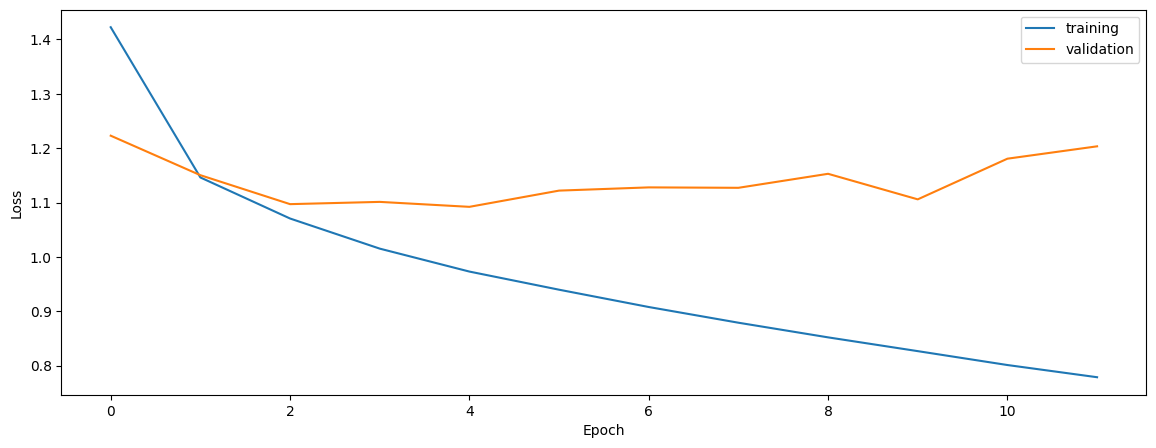

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6294381447088558
0.5691125544854677
0.5531557705020702


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5725423986614951
0.5647590361445783
0.51982897779329


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5731764037104984
0.5588073495434042
0.5200871707409513


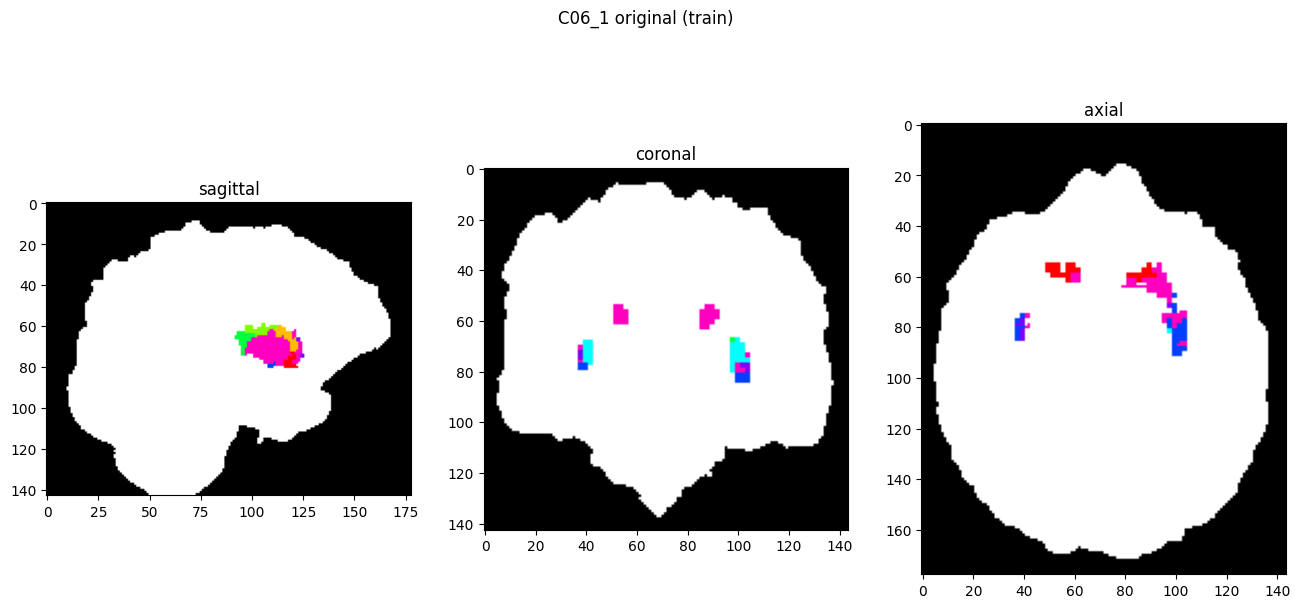

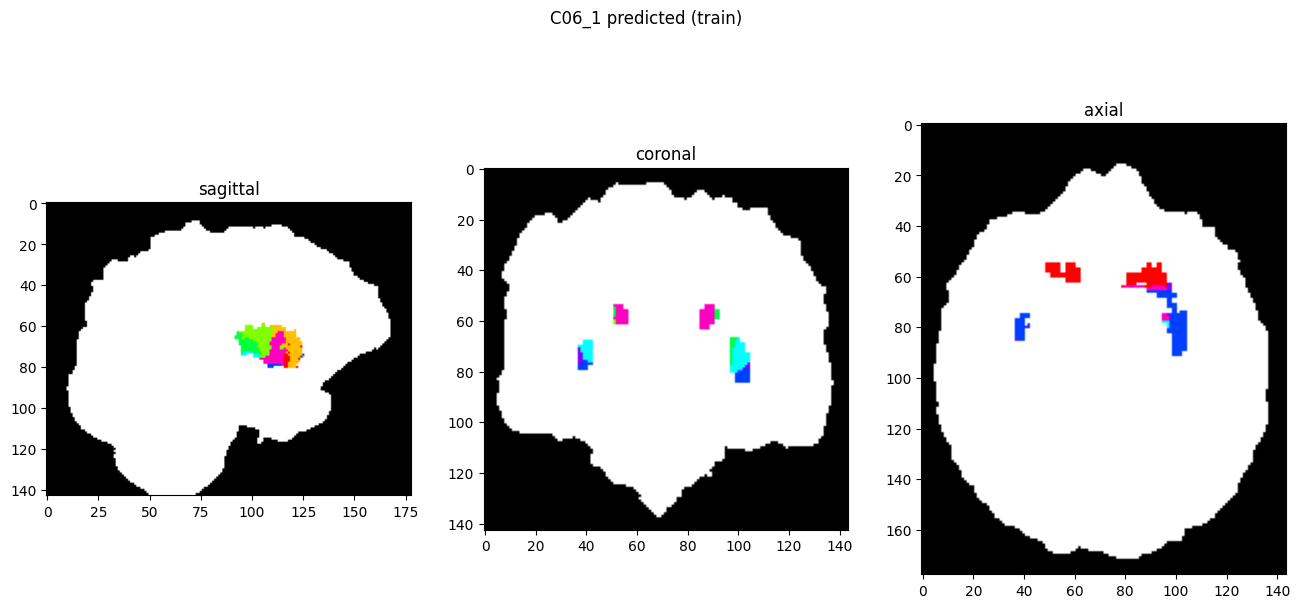

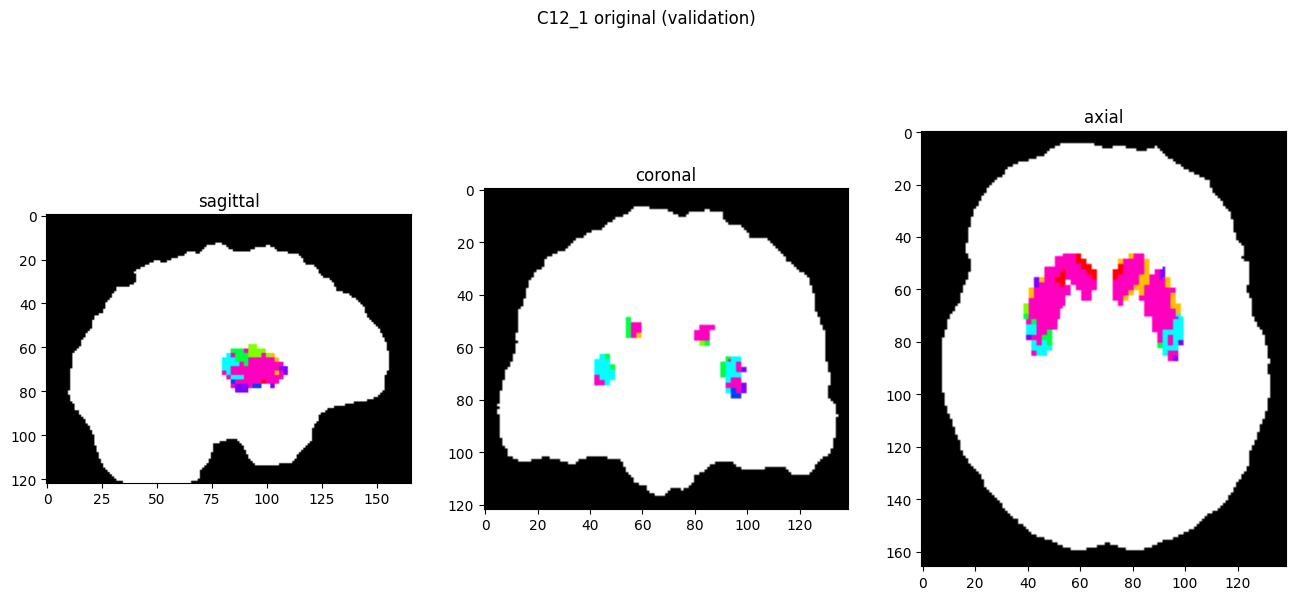

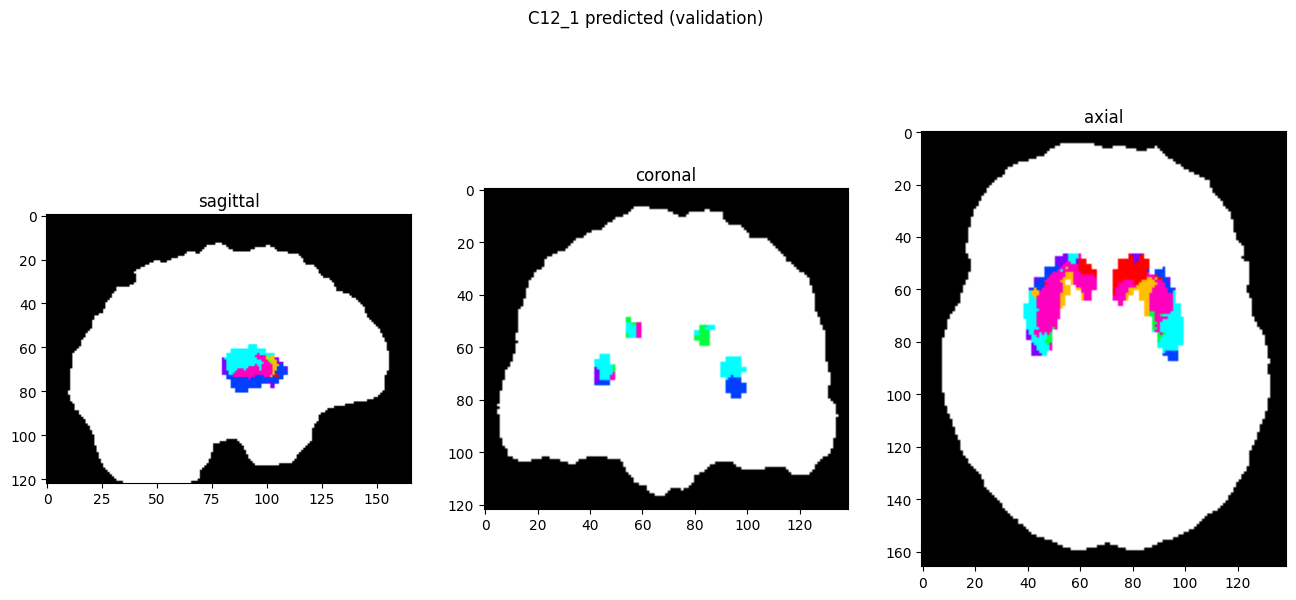

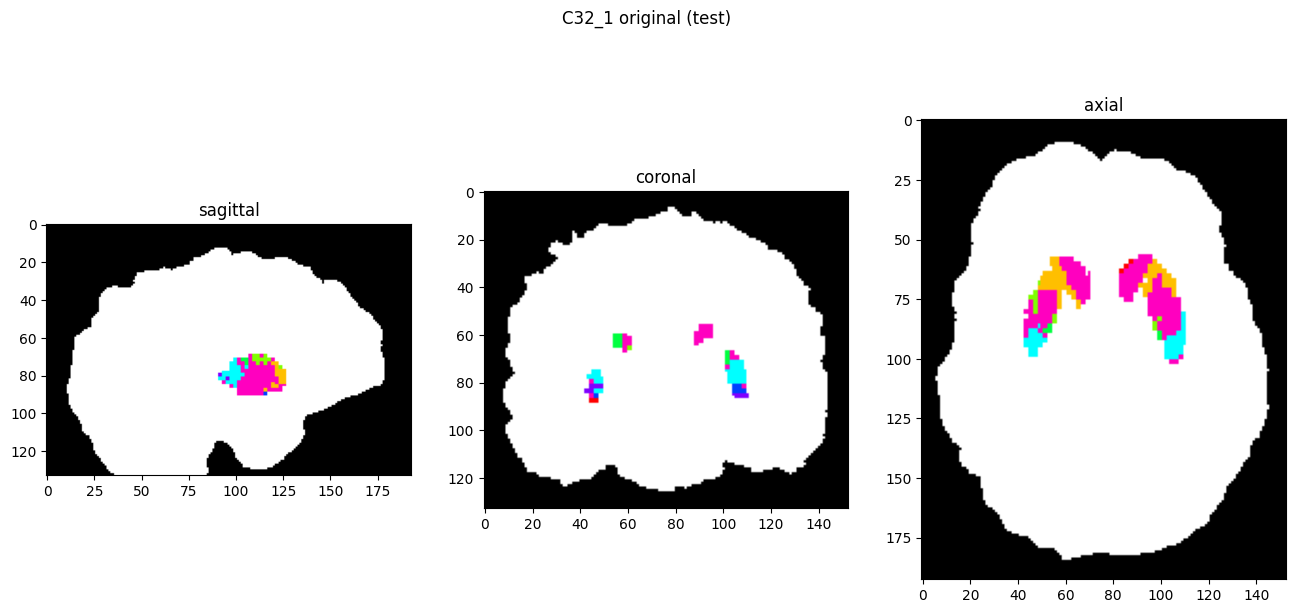

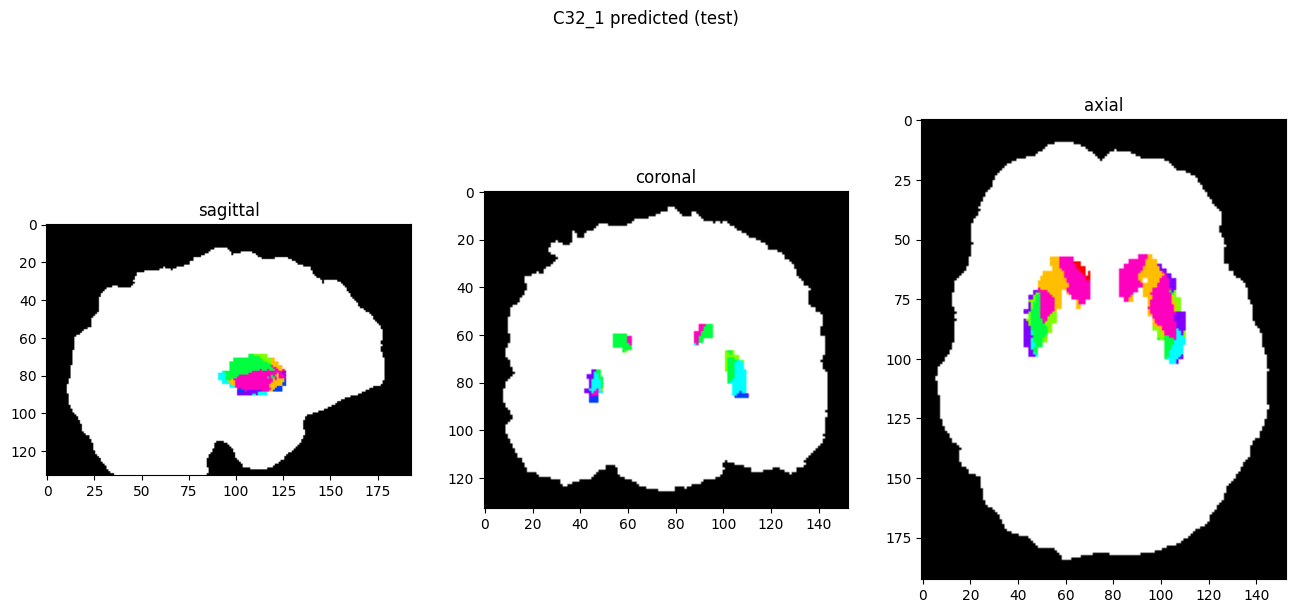

In [10]:
showResults(model, gen, threshold=0)